In [1]:
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(6)
tf.config.threading.set_inter_op_parallelism_threads(6)


2024-04-21 10:50:27.600403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 10:50:28.112377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import scipy.io
import numpy as np
import mne
import os
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [3]:
import numpy as np
import pywt

def min_max_scale_signal(signal, min_val=-1, max_val=1):
    """
    Scale the signal to a new range [min_val, max_val].

    Parameters:
    - signal: Input signal, a numpy array.
    - min_val: Minimum value of the scaled range.
    - max_val: Maximum value of the scaled range.

    Returns:
    - Scaled signal.
    """
    min_signal = np.min(signal)
    max_signal = np.max(signal)
    scaled_signal = (signal - min_signal) / (max_signal - min_signal) * (max_val - min_val) + min_val
    return scaled_signal

def pad_sequences(sequences, target_length, axis=-1):
    """ Pad sequences to the desired length with zeros.

    Args:
        sequences (np.ndarray): The array of sequences to pad.
        target_length (int): The desired length of each sequence.
        axis (int): The axis along which to pad.

    Returns:
        np.ndarray: The padded sequences array.
    """
    padding = [(0, 0)] * sequences.ndim
    padding[axis] = (0, target_length - sequences.shape[axis])
    return np.pad(sequences, pad_width=padding, mode='constant')

In [4]:
# import os
# import numpy as np
# from scipy.io import loadmat

# # Initialize dictionaries to hold categorized data, with subjects as keys
# forward_saccade_dataset = {}
# return_saccade_dataset = {}
# blink_dataset = {}

# # Specify the directory where your formatted data is located
# dataset_dir = '/mnt/Data/Data/EEG_Converted/PhysionetEOG/DATASET'
# fs = 256  # Sampling frequency, meaning one second is represented by 256 samples

# # Iterate through each subject's folder within the data directory
# for subject_folder in os.listdir(dataset_dir):
#     subject_dir = os.path.join(dataset_dir, subject_folder)
    
#     if os.path.isdir(subject_dir):
#         subject_id = subject_folder
#         eog_path = os.path.join(subject_dir, 'EOG.mat')
#         control_signal_path = os.path.join(subject_dir, 'ControlSignal.mat')

#         eog_data = loadmat(eog_path)['EOG']
#         control_signal_data = loadmat(control_signal_path)['ControlSignal'].flatten()

#         # Initialize lists for categorized data
#         forward_saccade_dataset[subject_id] = []
#         return_saccade_dataset[subject_id] = []
#         blink_dataset[subject_id] = []

#         i = 0
#         while i < len(control_signal_data):
#             if control_signal_data[i] == 1 and i + fs <= len(control_signal_data):  # Check for forward saccade
#                 forward_saccade_dataset[subject_id].append(eog_data[:, i:i + fs])
#                 i += fs  # Skip the next fs samples as they are part of this event
#             elif control_signal_data[i] == 2 and i + fs <= len(control_signal_data):  # Check for return saccade
#                 return_saccade_dataset[subject_id].append(eog_data[:, i:i + fs])
#                 i += fs
#             elif control_signal_data[i] == 3 and i + 2 * fs <= len(control_signal_data):  # Check for blink
#                 blink_dataset[subject_id].append(eog_data[:, i:i + 2 * fs])
#                 i += 2 * fs
#             else:
#                 i += 1  # Increment index if no event is matched or insufficient data remains

# # Apply any necessary scaling and padding
# for subject_id in forward_saccade_dataset:
#     forward_saccade_dataset[subject_id] = np.array(forward_saccade_dataset[subject_id])
#     return_saccade_dataset[subject_id] = np.array(return_saccade_dataset[subject_id])
#     blink_dataset[subject_id] = np.array(blink_dataset[subject_id])

#     if len(forward_saccade_dataset[subject_id]) > 0:
#         forward_saccade_dataset[subject_id] = min_max_scale_signal(forward_saccade_dataset[subject_id])
#     if len(return_saccade_dataset[subject_id]) > 0:
#         return_saccade_dataset[subject_id] = min_max_scale_signal(return_saccade_dataset[subject_id])
#     if len(blink_dataset[subject_id]) > 0:
#         blink_dataset[subject_id] = min_max_scale_signal(blink_dataset[subject_id])

import os
import numpy as np
from scipy.io import loadmat

forward_saccade_dataset = {}
return_saccade_dataset = {}
blink_dataset = {}

# Specify the directory where your formatted data is located
dataset_dir = '/mnt/Data/Data/EEG_Converted/PhysionetEOG/DATASET'

# Iterate through each subject's folder within the data directory
for subject_folder in os.listdir(dataset_dir):
    subject_dir = os.path.join(dataset_dir, subject_folder)
    
    if os.path.isdir(subject_dir):
        subject_id = subject_folder
        eog_path = os.path.join(subject_dir, 'EOG.mat')
        control_signal_path = os.path.join(subject_dir, 'ControlSignal.mat')

        eog_data = loadmat(eog_path)['EOG']
        control_signal_data = loadmat(control_signal_path)['ControlSignal'].flatten()

        # Initialize lists for categorized data
        forward_saccade_dataset[subject_id] = []
        return_saccade_dataset[subject_id] = []
        blink_dataset[subject_id] = []

        # To store maximum segment length
        max_segment_length = 0

        i = 0
        while i < len(control_signal_data):
            start_index = i
            while i < len(control_signal_data) and control_signal_data[i] == control_signal_data[start_index]:
                i += 1

            segment_length = i - start_index
            max_segment_length = max(max_segment_length, segment_length)
            segment = eog_data[:, start_index:start_index + segment_length]
            segment = segment.reshape(1, 2, segment_length)  # Reshape to (1, 2, segment_length)

            if control_signal_data[start_index] == 1:
                forward_saccade_dataset[subject_id].append(segment)
            elif control_signal_data[start_index] == 2:
                return_saccade_dataset[subject_id].append(segment)
            elif control_signal_data[start_index] == 3:
                blink_dataset[subject_id].append(segment)

        # Pad and store each dataset after all segments are identified
        for dataset in [forward_saccade_dataset, return_saccade_dataset, blink_dataset]:
            padded_data = [pad_sequences(seg, target_length=max_segment_length, axis=2) for seg in dataset[subject_id]]
            dataset[subject_id] = np.concatenate(padded_data, axis=0)  # Concatenate along the first axis

In [36]:
targetga_data = loadmat('/mnt/Data/Data/EEG_Converted/PhysionetEOG/DATASET/S1/TargetGA.mat')['TargetGA']
np.set_printoptions(threshold=np.inf)
print(targetga_data.shape, targetga_data)

(600, 2) [[ -3.80653656  -1.0377855 ]
 [  0.           0.        ]
 [ 19.47069849 -13.19181552]
 [  0.           0.        ]
 [ 13.95501766  11.27078733]
 [  0.           0.        ]
 [ 21.34328065   1.55127415]
 [  0.           0.        ]
 [  7.54448852  10.52750209]
 [  0.           0.        ]
 [-21.54572406 -12.31022433]
 [  0.           0.        ]
 [ 16.53620401  13.17208335]
 [  0.           0.        ]
 [ 20.25756951  -7.4001805 ]
 [  0.           0.        ]
 [  8.64263928  -8.52565753]
 [  0.           0.        ]
 [ 12.36277377  -9.88112967]
 [  0.           0.        ]
 [ 11.68191105  11.10770686]
 [  0.           0.        ]
 [ -5.23656146   2.71077896]
 [  0.           0.        ]
 [  7.53190365   6.47244254]
 [  0.           0.        ]
 [-15.62227514  -8.06884499]
 [  0.           0.        ]
 [  9.93860953   1.85592337]
 [  0.           0.        ]
 [-21.70904472 -10.97950304]
 [  0.           0.        ]
 [-10.74168481   8.54815273]
 [  0.           0.        ]
 [-21

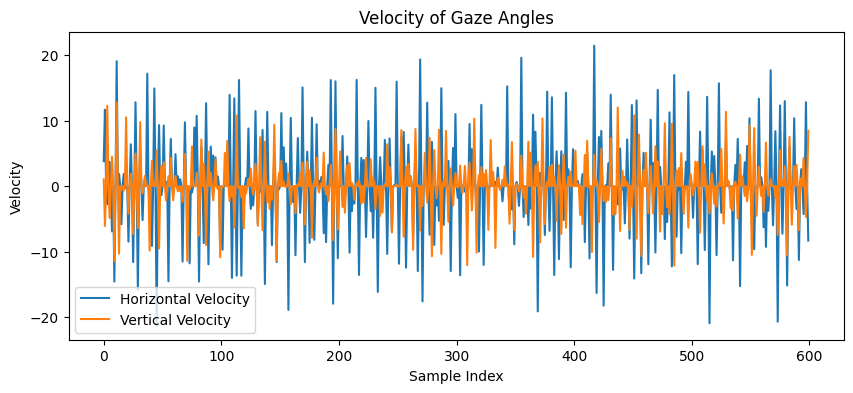

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'gaze_data' is your array of shape (600, 2)
# Calculate the first derivative (velocity) of gaze angles
velocity = np.gradient(targetga_data, axis=0)

# Plot velocity
plt.figure(figsize=(10, 4))
plt.plot(velocity[:, 0], label='Horizontal Velocity')
plt.plot(velocity[:, 1], label='Vertical Velocity')
plt.title('Velocity of Gaze Angles')
plt.xlabel('Sample Index')
plt.ylabel('Velocity')
plt.legend()
plt.show()


In [5]:
for k in forward_saccade_dataset:
    forward_saccade_dataset[k] = min_max_scale_signal(forward_saccade_dataset[k][:,:,:512])
for k in return_saccade_dataset:
    return_saccade_dataset[k] = min_max_scale_signal(return_saccade_dataset[k][:,:,:512])
for k in blink_dataset:
    blink_dataset[k] = min_max_scale_signal(blink_dataset[k][:,:,:512])

In [6]:
for k in forward_saccade_dataset:
    print(k,forward_saccade_dataset[k].shape)
    
    print(k,return_saccade_dataset[k].shape)
    print(k,blink_dataset[k].shape)

S4 (300, 2, 512)
S4 (300, 2, 512)
S4 (300, 2, 512)
S1 (300, 2, 512)
S1 (300, 2, 512)
S1 (300, 2, 512)
S3 (300, 2, 512)
S3 (300, 2, 512)
S3 (300, 2, 512)
S2 (300, 2, 512)
S2 (300, 2, 512)
S2 (300, 2, 512)
S5 (300, 2, 512)
S5 (300, 2, 512)
S5 (300, 2, 512)
S6 (300, 2, 512)
S6 (300, 2, 512)
S6 (300, 2, 512)


In [7]:

# EOG channel names based on electrode positions
# V1(t) and V2(t) for vertical, V3(t) and V4(t) for horizontal EOG components
chan_names = ['EOG Vertical', 'EOG Horizontal']
ch_types = ['eog', 'eog']  # Channel types are EOG
sfreq = 256  # Sampling frequency

# Create an MNE Info object for the EOG data
info = mne.create_info(ch_names=chan_names, ch_types=ch_types, sfreq=sfreq)
info.set_montage('standard_1020')

print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: EOG Vertical, EOG Horizontal
 chs: 2 EOG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 2
 projs: []
 sfreq: 256.0 Hz
>


In [8]:
%%capture

forward_saccade_epochs = mne.EpochsArray(data=forward_saccade_dataset['S1'], info=info)
return_saccade_epochs = mne.EpochsArray(data=return_saccade_dataset['S1'], info=info)
blink_epochs = mne.EpochsArray(data=blink_dataset['S1'], info=info)
# extension_epochs1 = mne.EpochsArray(data=(extension_dataset), info=info)
# flexion_epochs1 = mne.EpochsArray(data=(flexion_dataset), info=info)
# rest_epochs1 = mne.EpochsArray(data=(rest_dataset), info=info)

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to plot the first segment of a given signal type
# def plot_first_segment(signal, title, fs=256):
#     for i in range(25):
#         plt.figure(figsize=(10, 4))
#         # Calculate the time axis based on the third dimension (number of samples)
#         time_axis = np.arange(signal.shape[2]) / fs
#         # Plot the horizontal and vertical components of the first segment
#         plt.plot(time_axis, signal[i, 0, :], label='Horizontal EOG')  # First segment, horizontal
#         plt.plot(time_axis, signal[i, 1, :], label='Vertical EOG')    # First segment, vertical
#         plt.xlabel('Time (s)')
#         plt.ylabel('EOG Signal')
#         plt.legend()
#         plt.title(title)
#         plt.show()

# # Plot the first segment for each signal type for subject 'S1'
# plot_first_segment(forward_saccade_dataset['S1'], 'Forward Saccade - Subject S1')
# plot_first_segment(return_saccade_dataset['S1'], 'Return Saccade - Subject S1')
# plot_first_segment(blink_dataset['S1'], 'Blink - Subject S1')


In [38]:
import scipy.io
import numpy as np
import mne
import os
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

ext_list = []
flex_list = []
rest_list = []

ext_list.append(forward_saccade_epochs.get_data())
flex_list.append(return_saccade_epochs.get_data())
rest_list.append(blink_epochs.get_data())
extension_labels = [0 for i in range(forward_saccade_epochs.get_data().shape[0])]
print(extension_labels)

flexion_labels = [1 for i in range(return_saccade_epochs.get_data().shape[0])]
print(flexion_labels)

rest_labels = [2 for i in range(blink_epochs.get_data().shape[0])]
print(rest_labels)

label_list = extension_labels + flexion_labels + rest_labels

forward_saccade_array = np.vstack(ext_list)
return_saccade_array = np.vstack(flex_list)
blink_array = np.vstack(rest_list)



label_array = np.hstack(label_list)

print(label_array.shape)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [43]:
import math
import pywt
import scipy.signal
from scipy import stats
def mean(x):
    return np.mean(x, axis=-1).reshape(-1, 1)

def stddev(x):
    return np.std(x, axis=-1).reshape(-1, 1)

def peaktopeak(x):
    return np.ptp(x, axis=-1).reshape(-1, 1)

def variance(x):
    return np.var(x, axis=-1).reshape(-1, 1)

def mini(x):
    return np.min(x, axis=-1).reshape(-1, 1)

def maxi(x):
    return np.max(x, axis=-1).reshape(-1, 1)

def argmini(x):
    return np.argmin(x, axis=-1).reshape(-1, 1)

def argmaxi(x):
    return np.argmax(x, axis=-1).reshape(-1, 1)

def rms(x):
    return np.sqrt(np.mean(x**2, axis=-1)).reshape(-1, 1)

def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1).reshape(-1, 1)

def skewness(x):
    return stats.skew(x, axis=-1).reshape(-1, 1)

def kurtosis(x):
    return stats.kurtosis(x, axis=-1).reshape(-1, 1)

def concat_features(x):
    features = np.concatenate(
        (
            peaktopeak(x),
            rms(x),
            abs_diff_signal(x),
            skewness(x),
            kurtosis(x),
            variance(x),
            mean(x),
            stddev(x)
        ),
        axis=1
    )
    return features

    
def featuresarray_load(data_array):
    features = []
    fs = 256
    for d in data_array:
        
        beta_ftrs = concat_features(d)
        
        _,p=scipy.signal.welch(d, fs=fs,average='median')
        
        res = np.concatenate((beta_ftrs,p),axis=1)
        
        features.append(res)
    return np.array(features)

def featuresarray_load(data_array, gaze_data):
    features = []
    fs = 256
    for idx, d in enumerate(data_array):
        beta_ftrs = concat_features(d)
        _, p = scipy.signal.welch(d, fs=fs, average='median')
        all_features = np.concatenate((beta_ftrs, p), axis=1)
        print(gaze_data[idx].reshape(-1,1).shape)
        # Adding respective gaze angles for each sample
        combined_features = np.concatenate([all_features, gaze_data[idx].reshape(1, -1)], axis=1)
        
        features.append(combined_features)
    return np.array(features)

def apply_cwt_to_dataset(dataset, scales=np.arange(1,33), wavelet='morl'):
    """
    Applies Continuous Wavelet Transform (CWT) to a dataset of signals.
    
    Parameters:
    - dataset: numpy array of shape (n_samples, n_channels, n_timepoints)
    - scales: array-like, scales to use for the CWT
    - wavelet: string or Wavelet object, wavelet to use
    
    Returns:
    - cwt_coeffs: numpy array of CWT coefficients, shape will depend on scales and input shape
    """
    # Initialize a list to hold the CWT coefficients for each sample
    cwt_coeffs_list = []

    # Iterate over each sample in the dataset
    for sample in dataset:
        # Initialize a list to hold the CWT coefficients for each channel in the sample
        sample_coeffs = []

        # Iterate over each channel in the sample
        for channel in sample:
            # Apply CWT on the current channel
            coeffs, _ = pywt.cwt(channel, scales, wavelet)
            # Append the coefficients for this channel to the sample's list
            sample_coeffs.append(coeffs)

        # Convert the list of coefficients for this sample to a numpy array and append to the main list
        # The resulting shape for each sample will be (n_channels, len(scales), n_timepoints)
        cwt_coeffs_list.append(np.array(sample_coeffs))

    # Convert the list of all samples' CWT coefficients to a numpy array
    # The resulting shape will be (n_samples, n_channels, len(scales), n_timepoints)
    cwt_coeffs = np.array(cwt_coeffs_list)

    return cwt_coeffs

In [44]:
f_ext = featuresarray_load(forward_saccade_array,targetga_data)
f_flex = featuresarray_load(return_saccade_array,targetga_data)
f_rest = featuresarray_load(blink_array)

np.save("f_sac_features_array.npy",allow_pickle=False,arr=f_ext)
np.save("r_sac_features_array.npy",allow_pickle=False,arr=f_flex)
np.save("blink_features_array.npy",allow_pickle=False,arr=f_rest)

(2, 1)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 1

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, LayerNormalization, Reshape
from keras.optimizers import Adam,SGD
from keras.metrics import categorical_crossentropy
from keras.backend import clear_session
from matplotlib.ticker import MultipleLocator
# features_array = np.load(file="features_array3.npy")
# GLOBAL_SHAPE_LENGTH = features_array.shape[1]
# scaler = StandardScaler()
# features_array = scaler.fit_transform(features_array)

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, LayerNormalization, Reshape
from keras.optimizers import Adam,SGD
from keras.metrics import categorical_crossentropy
from keras.backend import clear_session
from imblearn.over_sampling import SMOTE

f_features_array = np.load(file="f_sac_features_array.npy")
r_features_array = np.load(file="r_sac_features_array.npy")
b_features_array = np.load(file="blink_features_array.npy")
features_array = np.concatenate((f_features_array,r_features_array,b_features_array))


print(features_array.shape)
GLOBAL_SHAPE_LENGTH = features_array.shape[2]
ncomp = features_array.shape[1]
print(GLOBAL_SHAPE_LENGTH,ncomp)

scaler = MinMaxScaler((-1,1))


X_train, X_test, y_train, y_test = train_test_split(features_array, label_array, test_size=.2, random_state=42, shuffle=True, stratify=label_array)
features_array  = scaler.fit_transform(features_array.reshape(-1, features_array.shape[-1])).reshape(features_array.shape)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
lst = y_train.tolist()
print(lst.count(0),lst.count(1),lst.count(2),GLOBAL_SHAPE_LENGTH)

lst = y_test.tolist()
print(lst.count(0),lst.count(1),lst.count(2),GLOBAL_SHAPE_LENGTH)

scaler = MinMaxScaler((-1,1))

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

(900, 2, 32, 512)
32 2
(720, 2, 32, 512)
(180, 2, 32, 512)
(720,)
(180,)
240 240 240 32
60 60 60 32


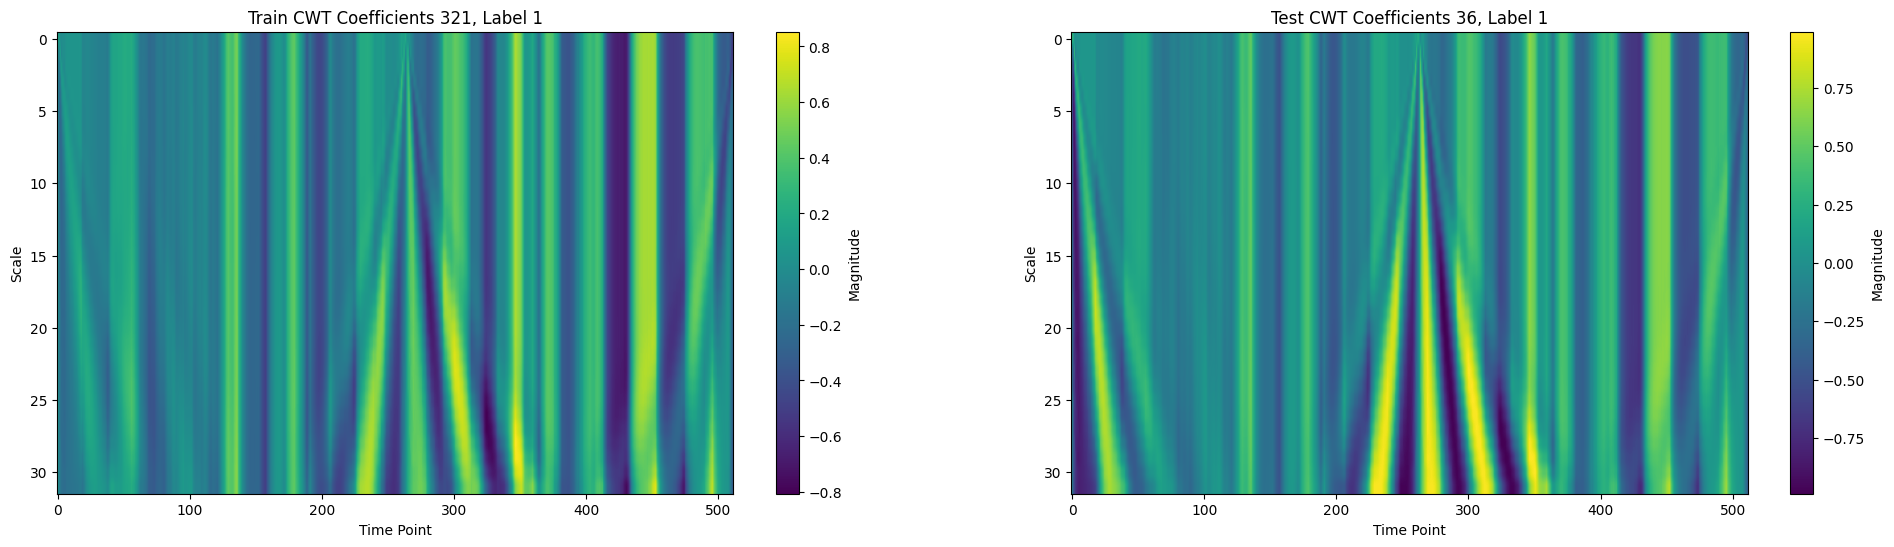

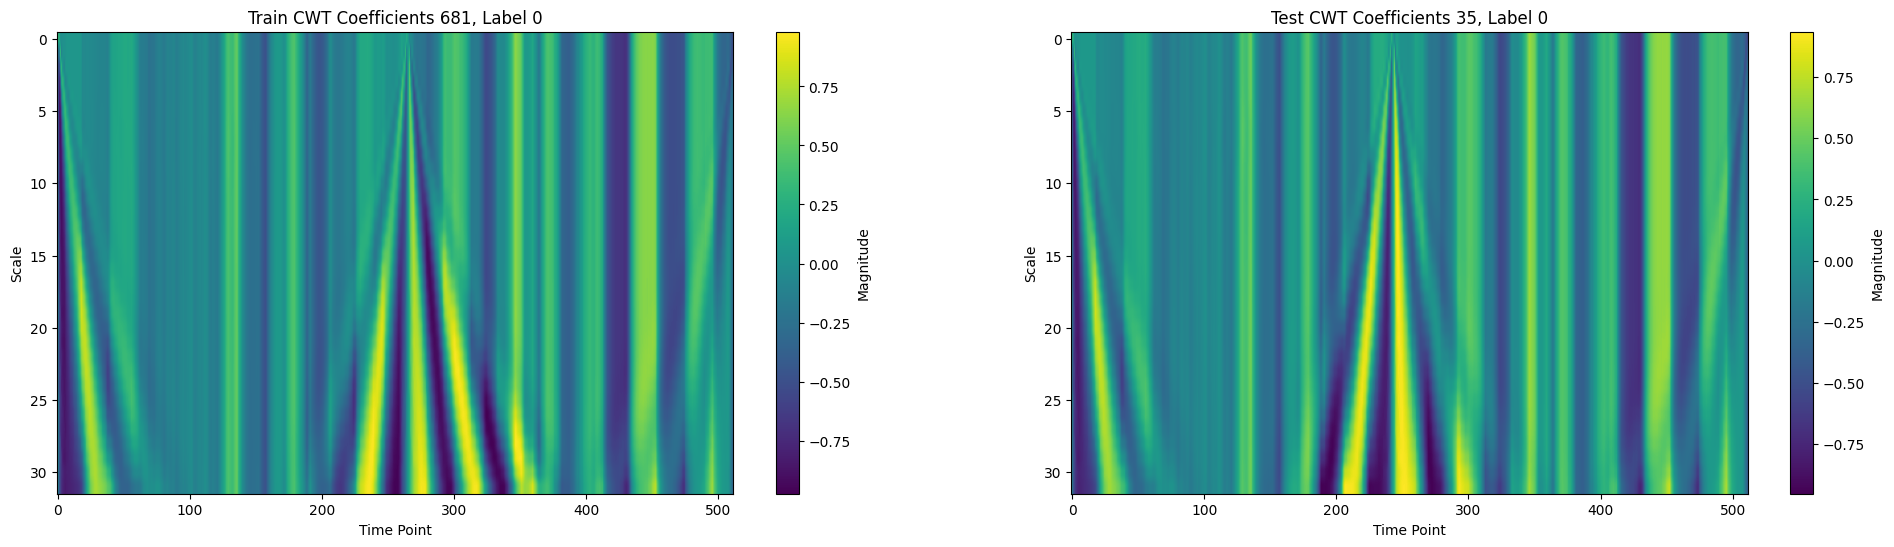

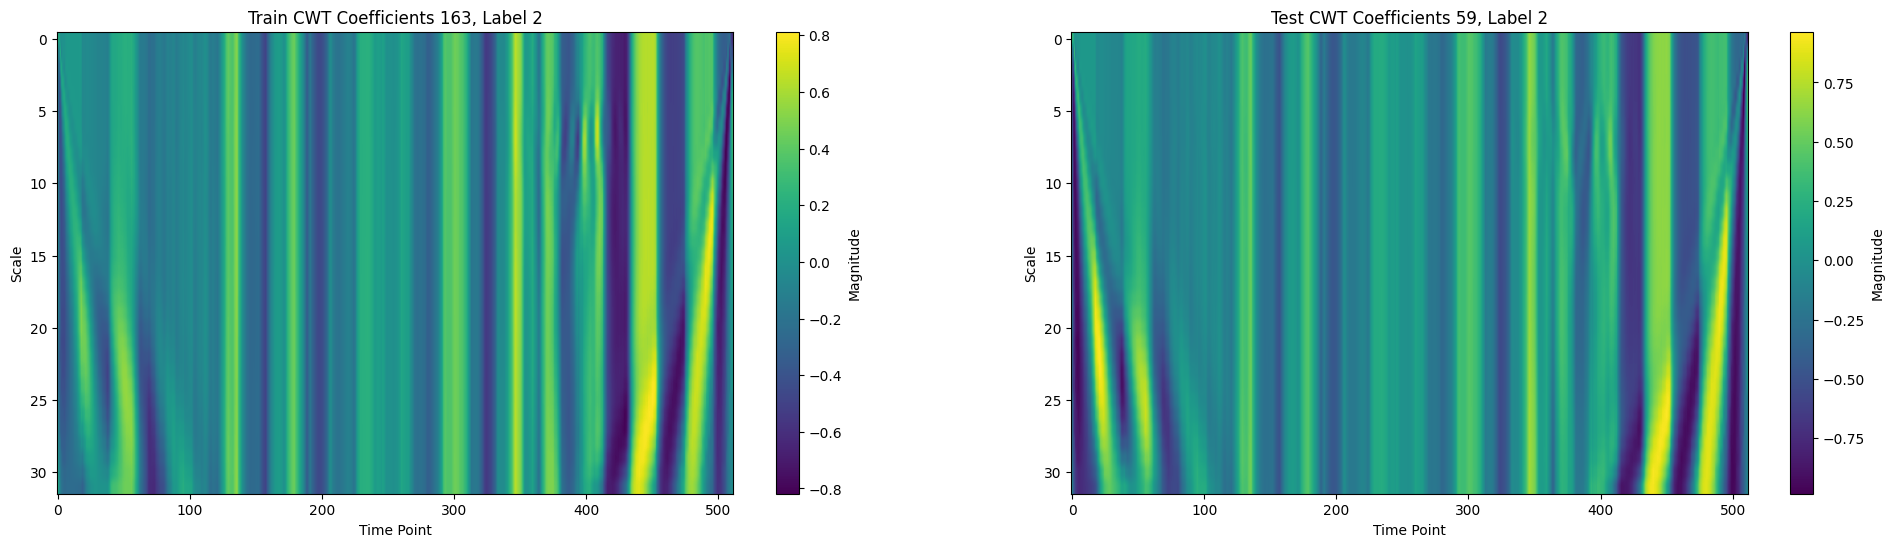

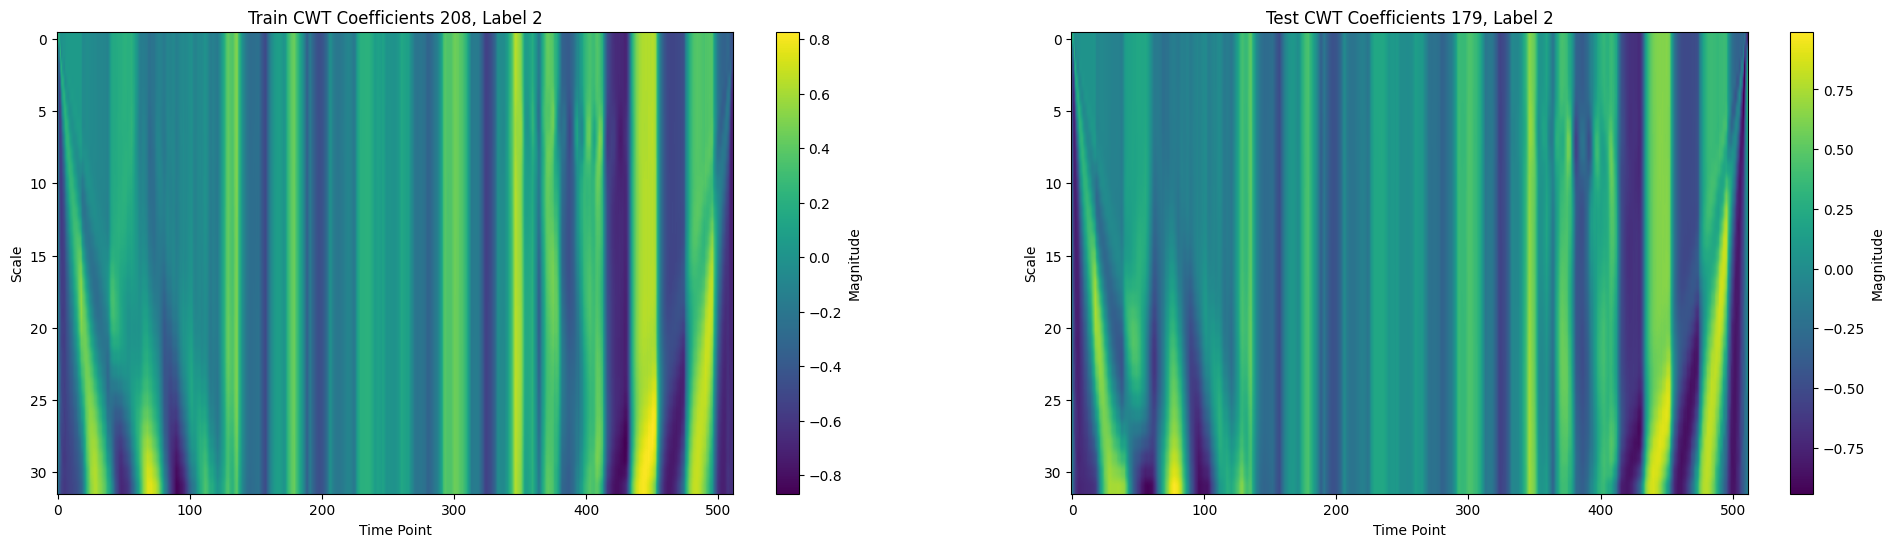

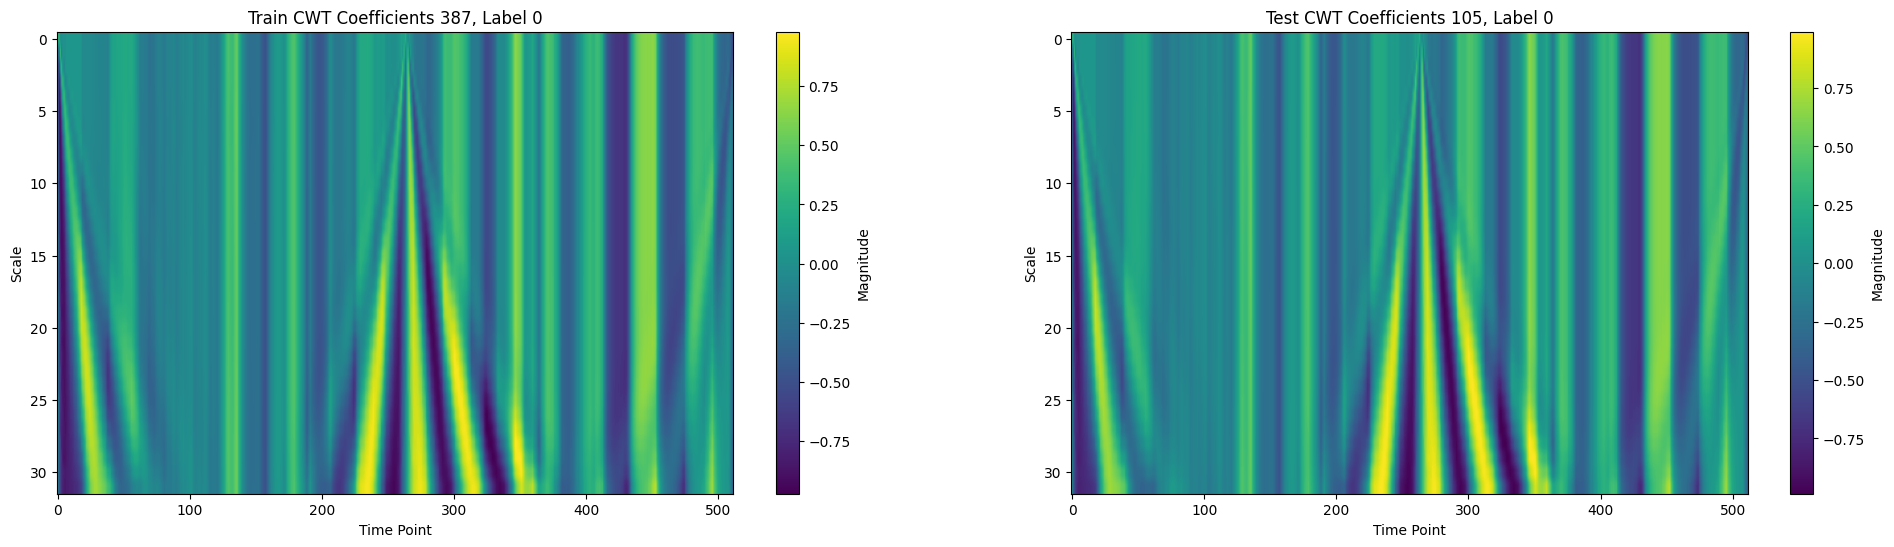

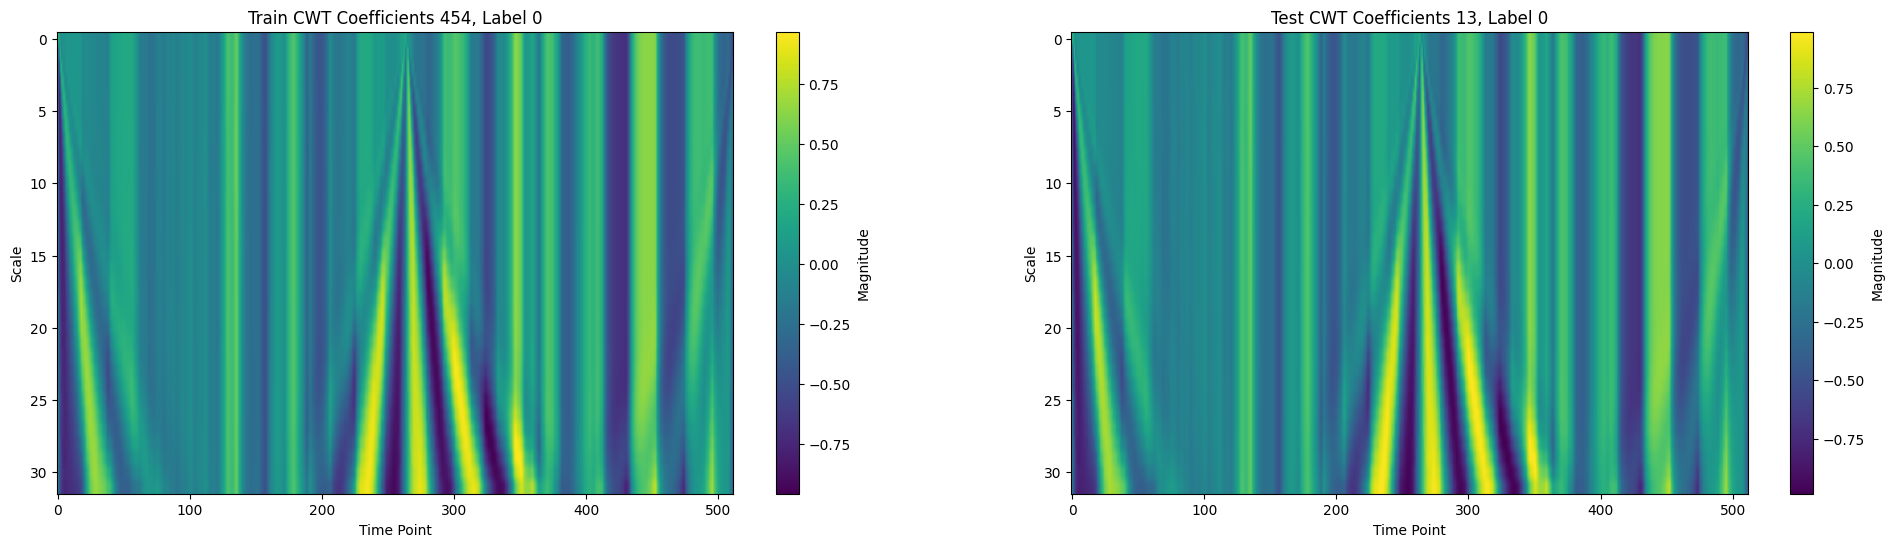

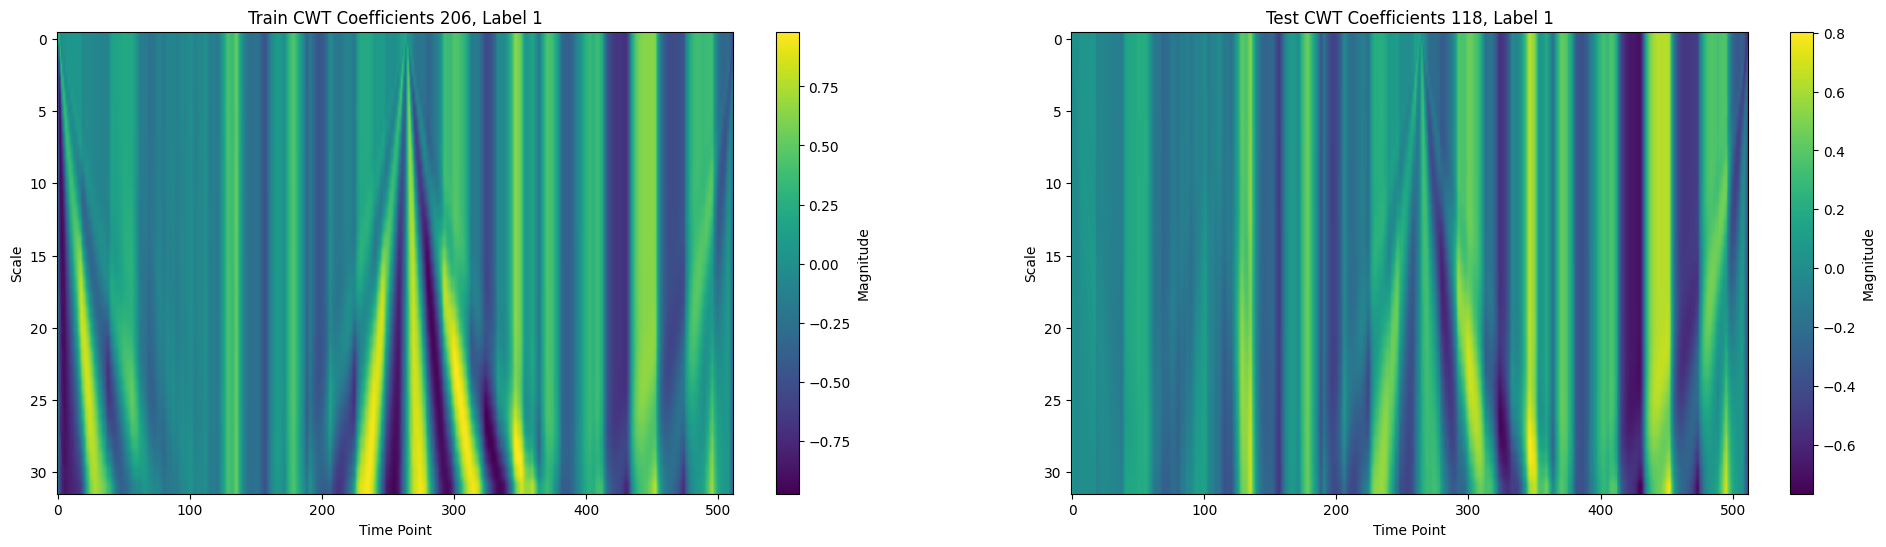

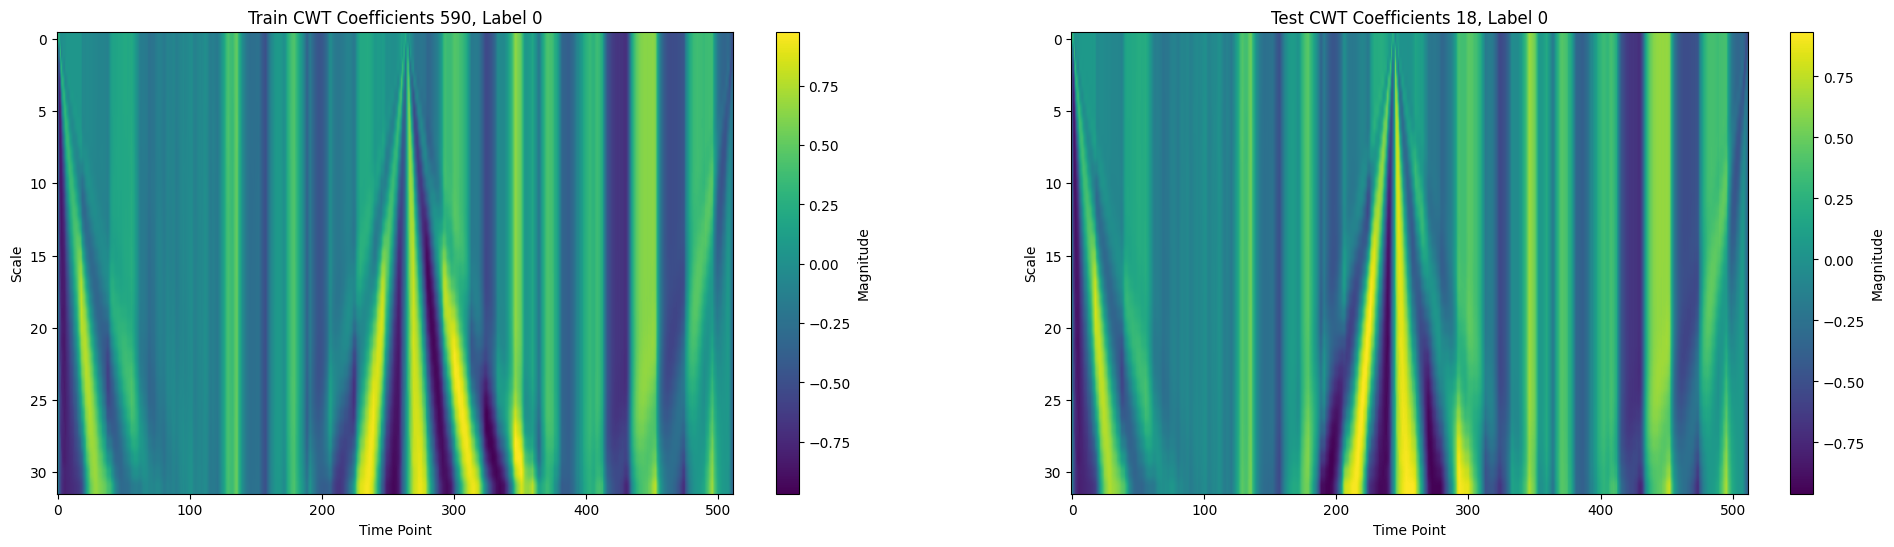

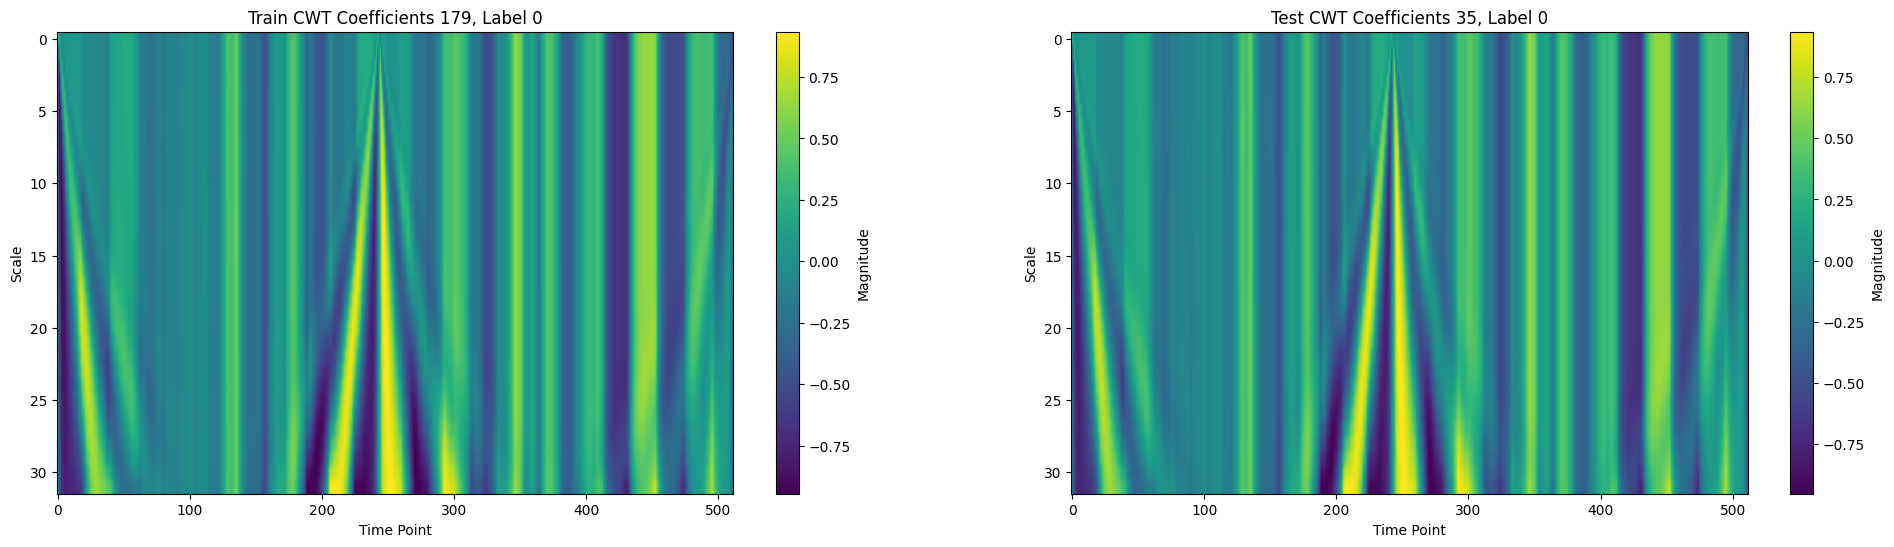

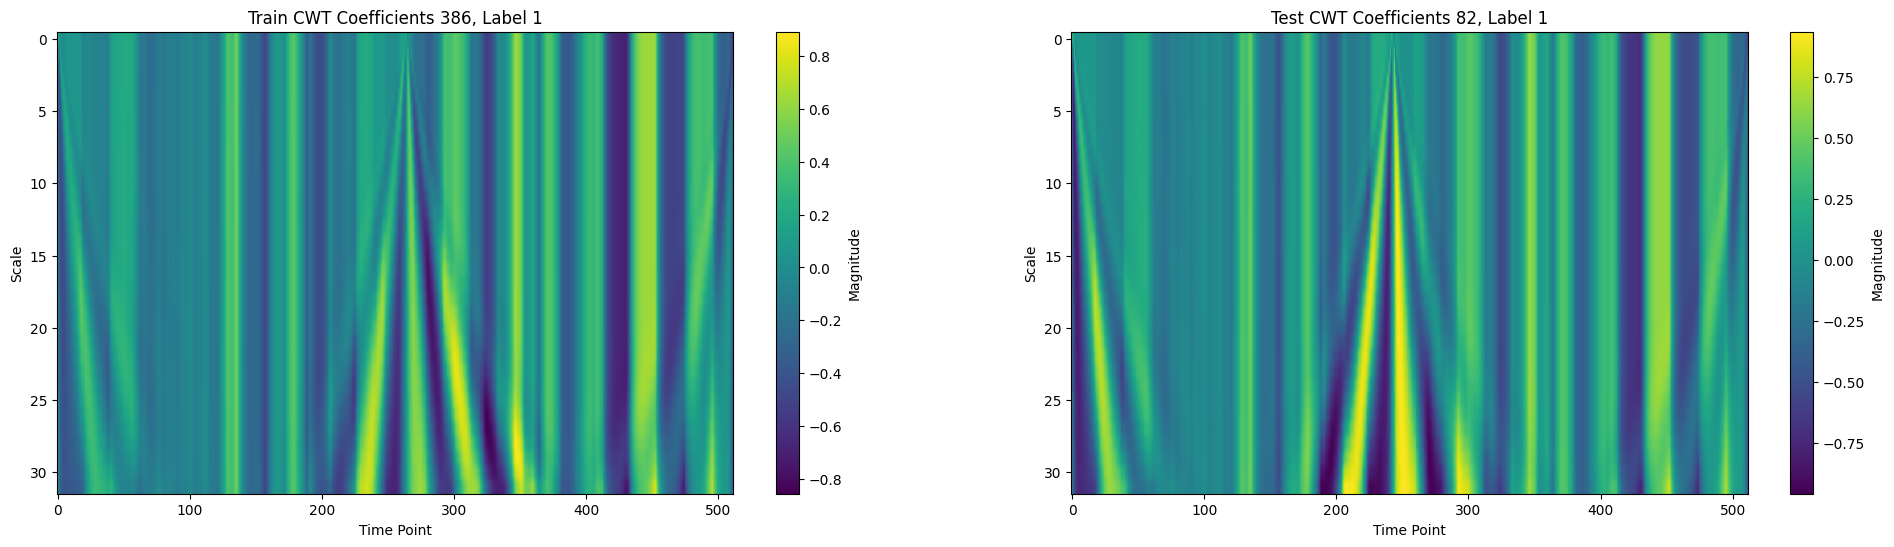

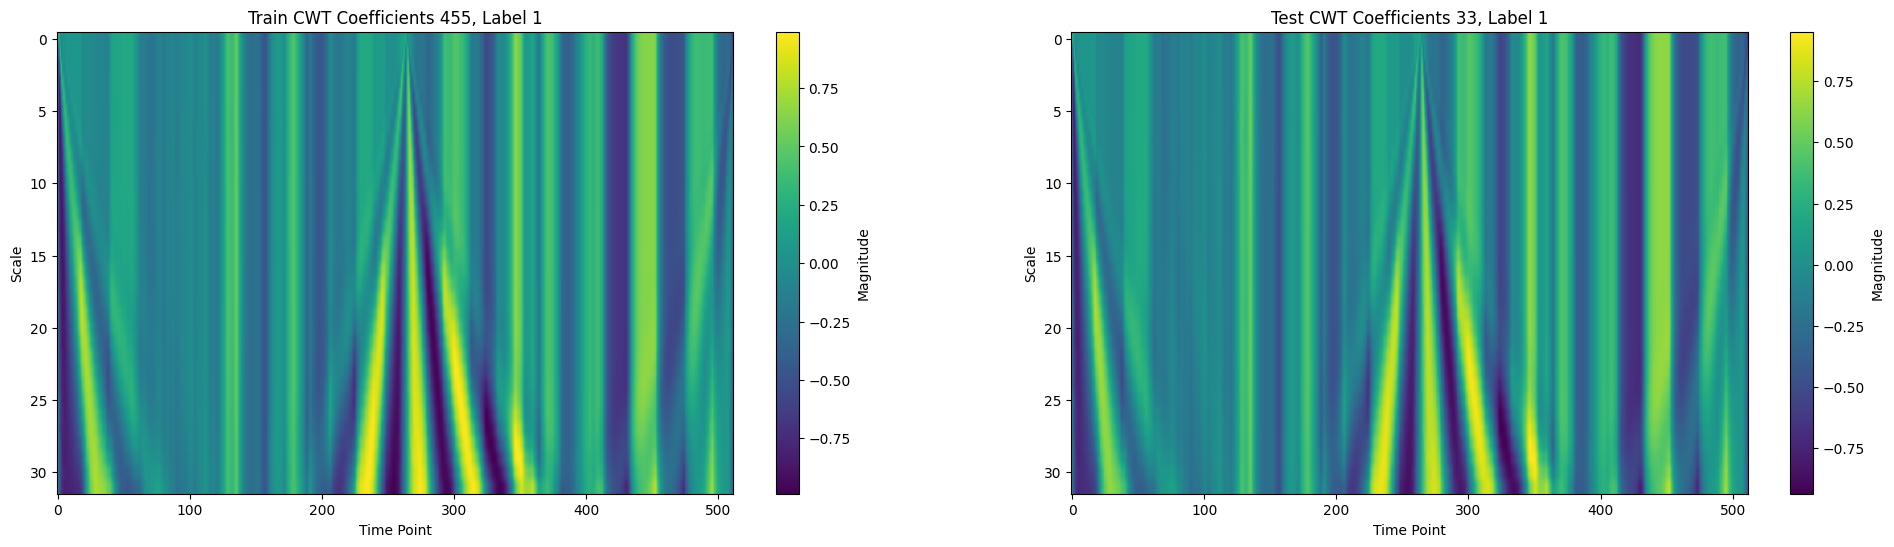

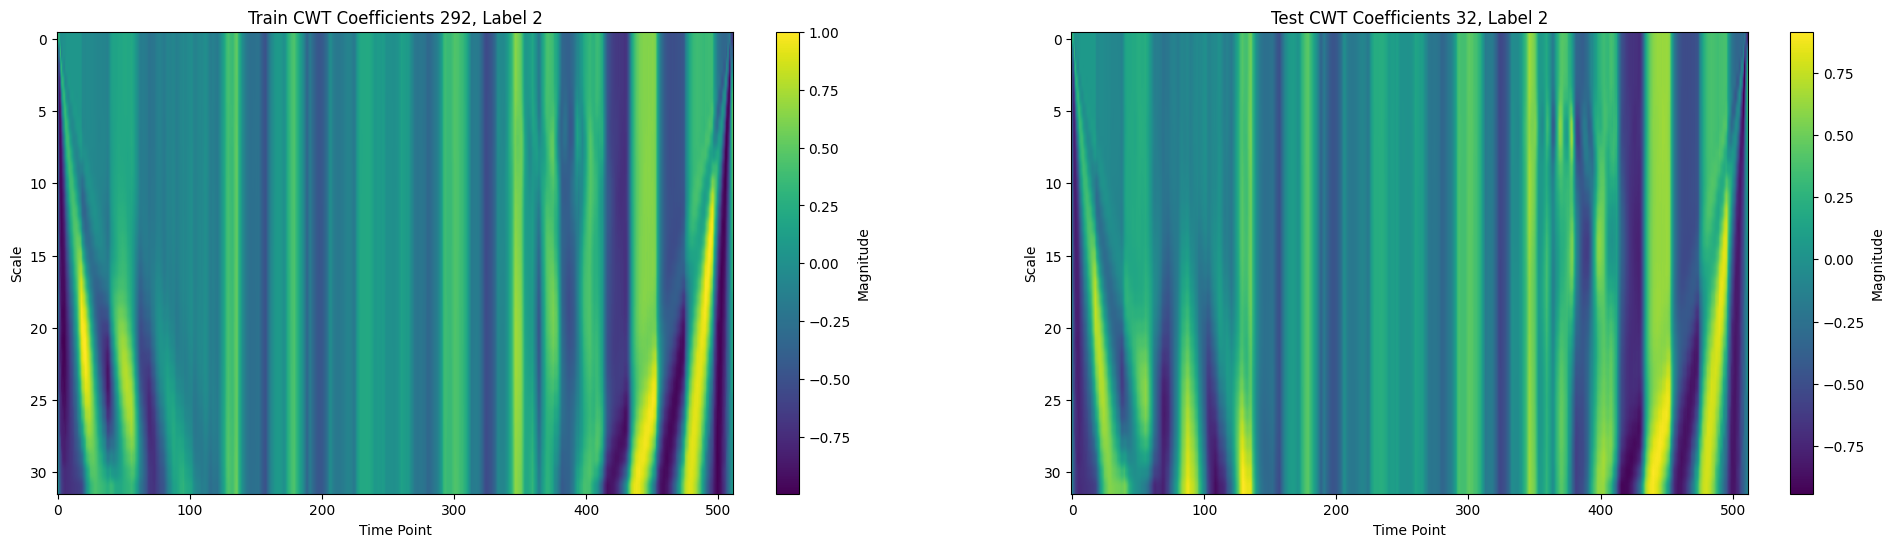

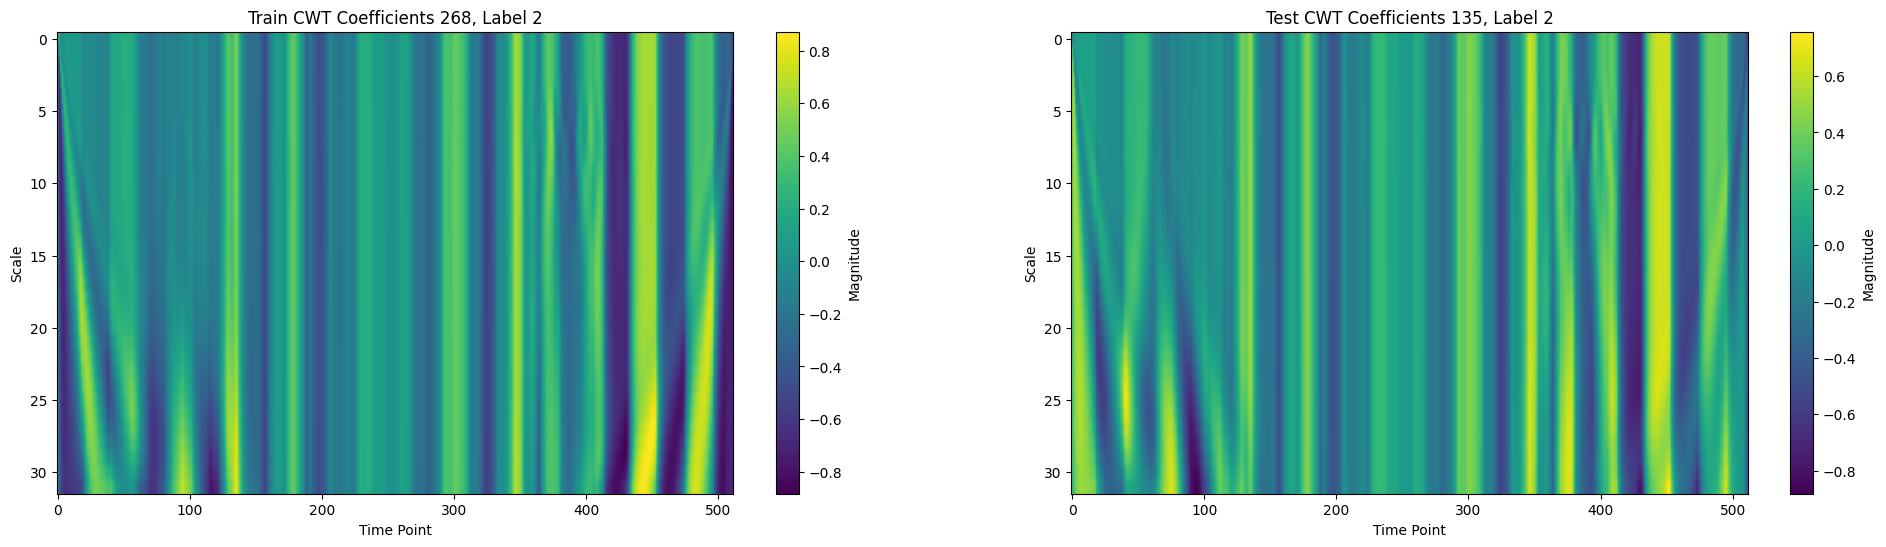

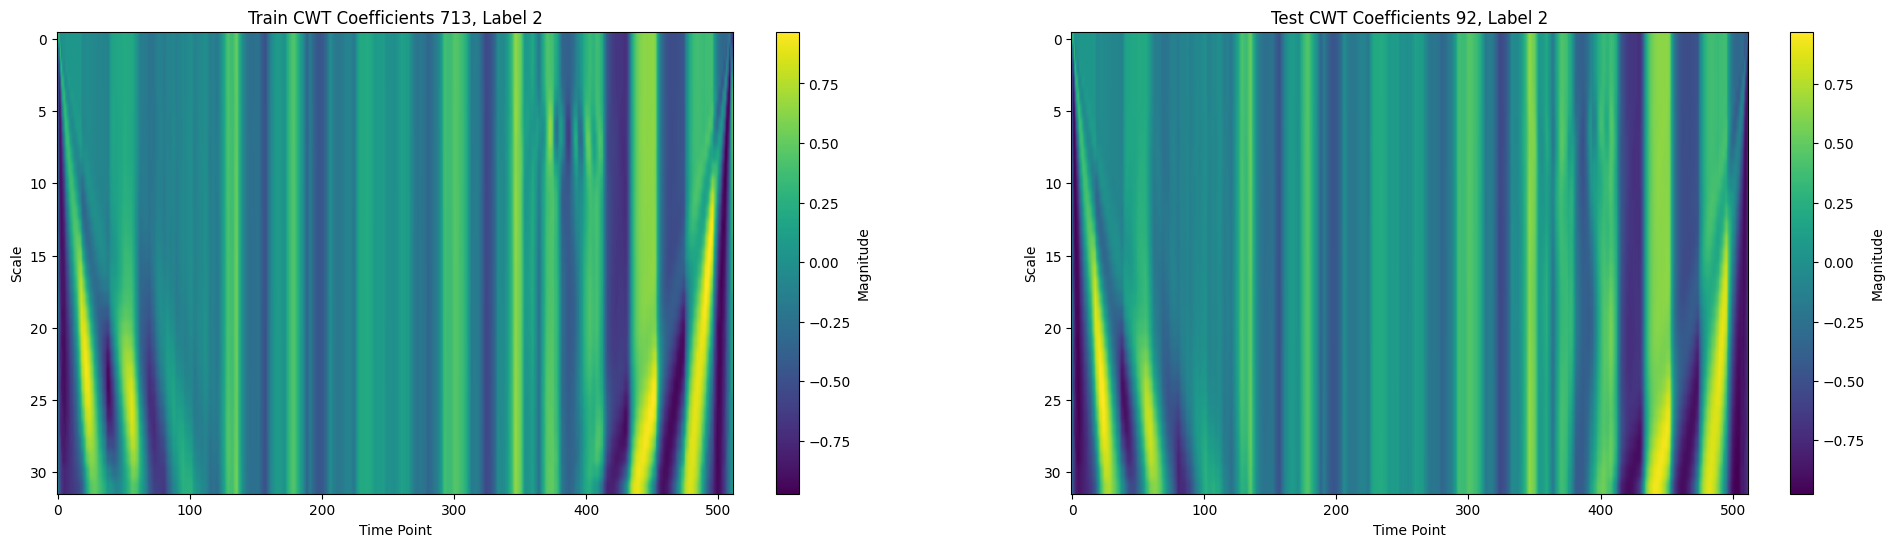

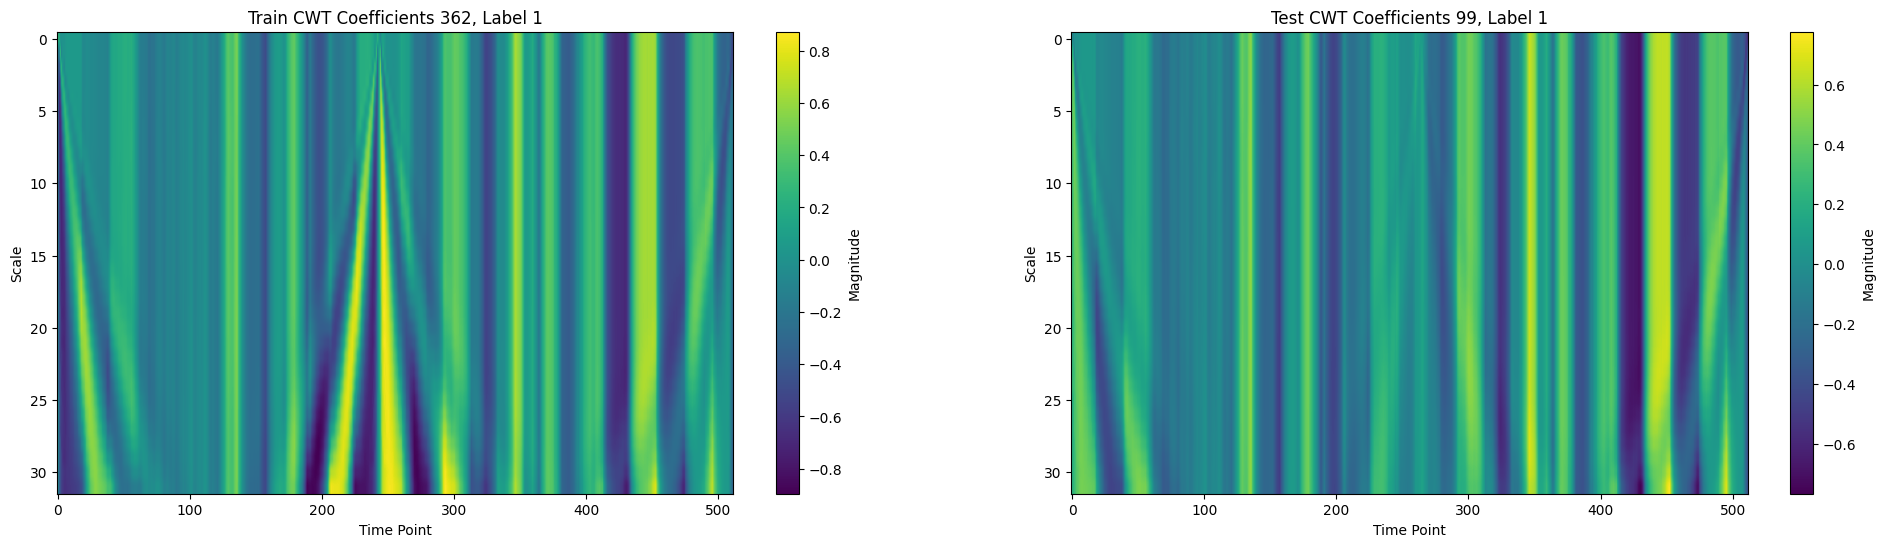

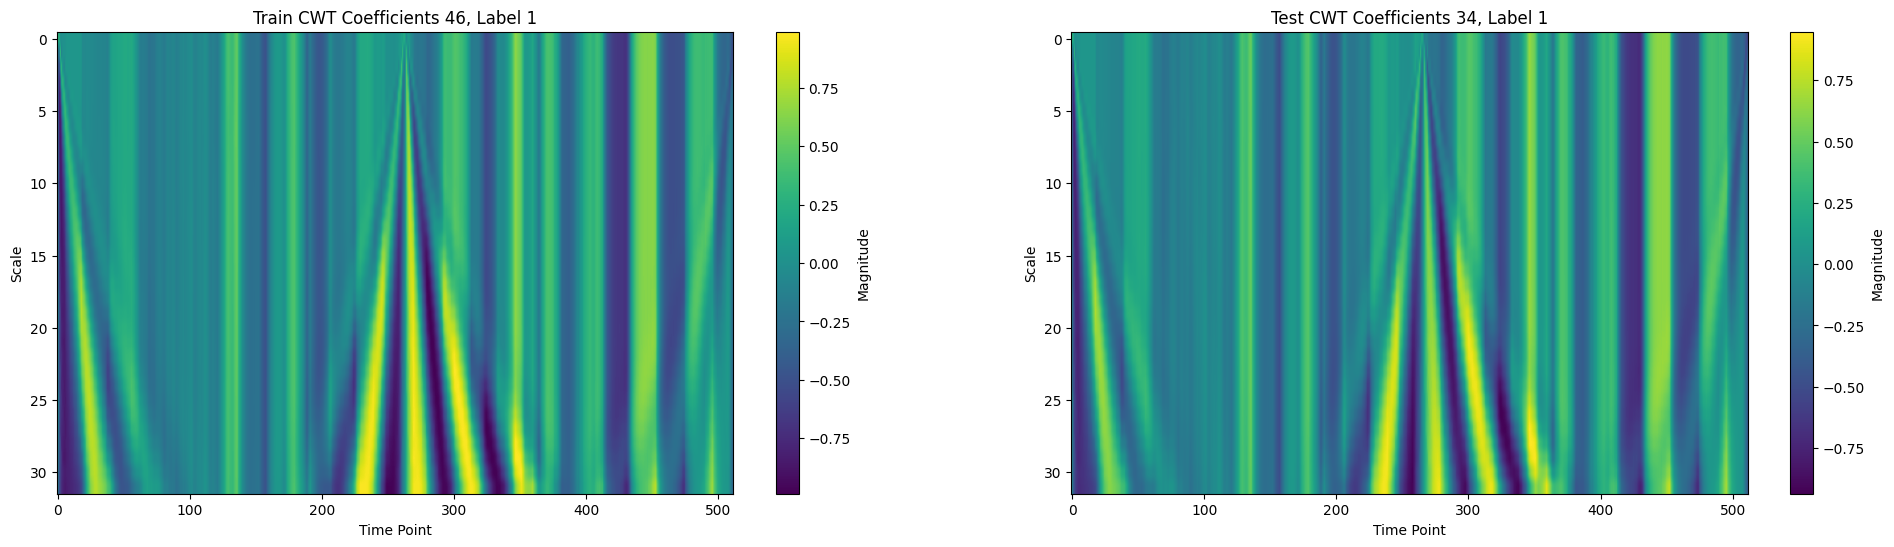

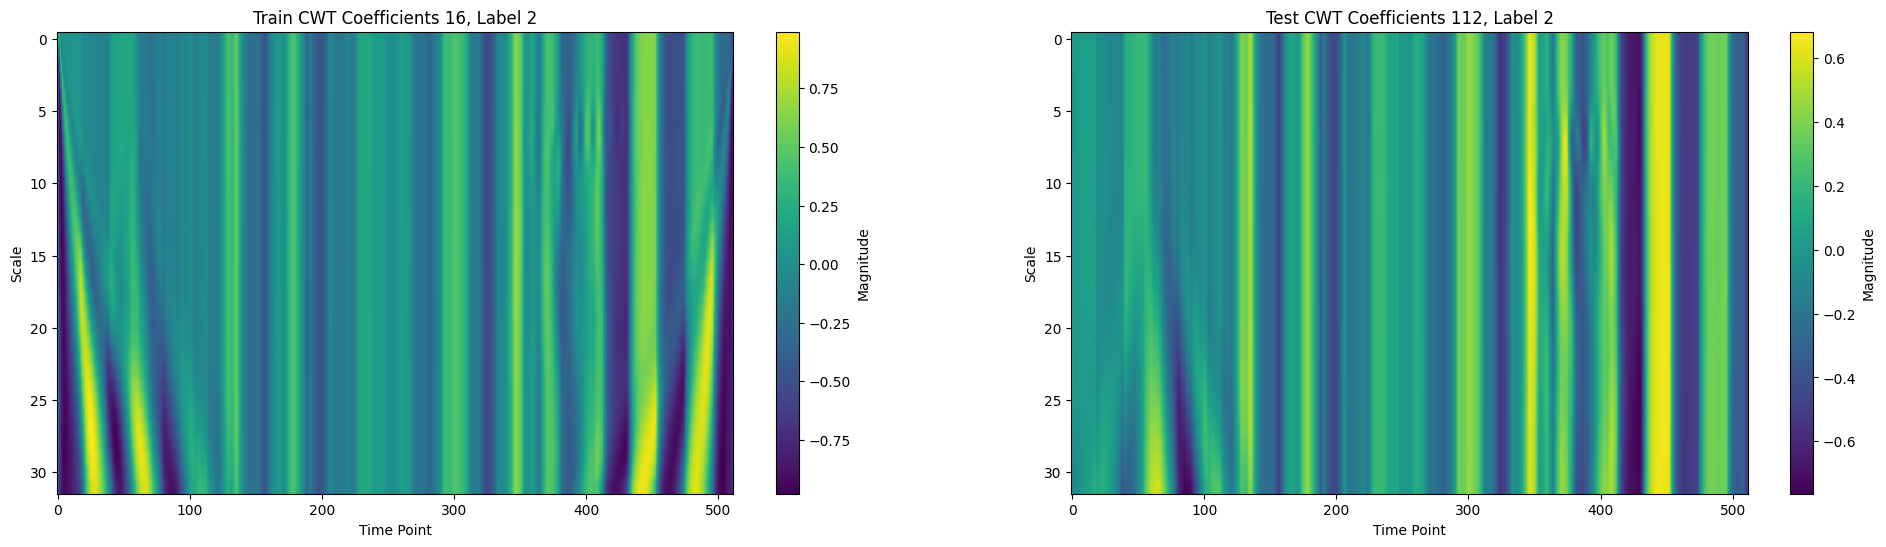

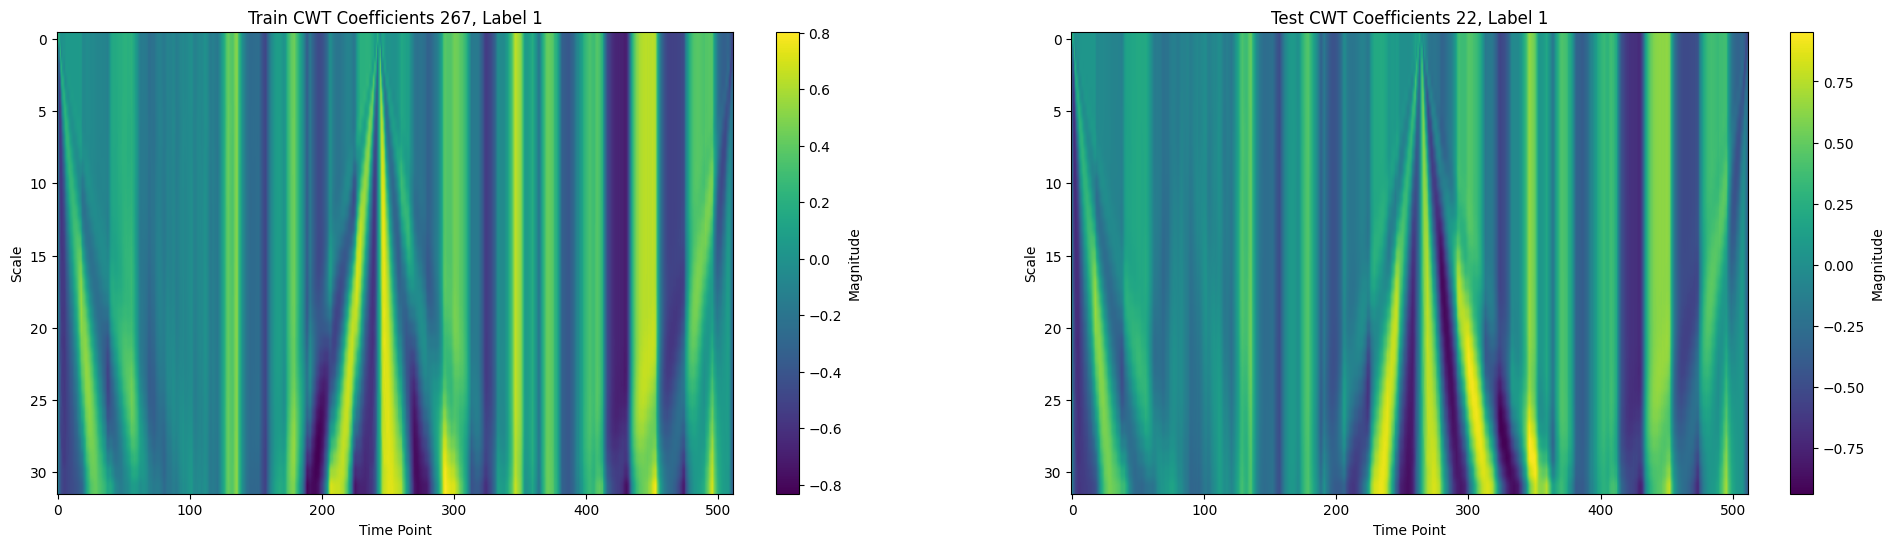

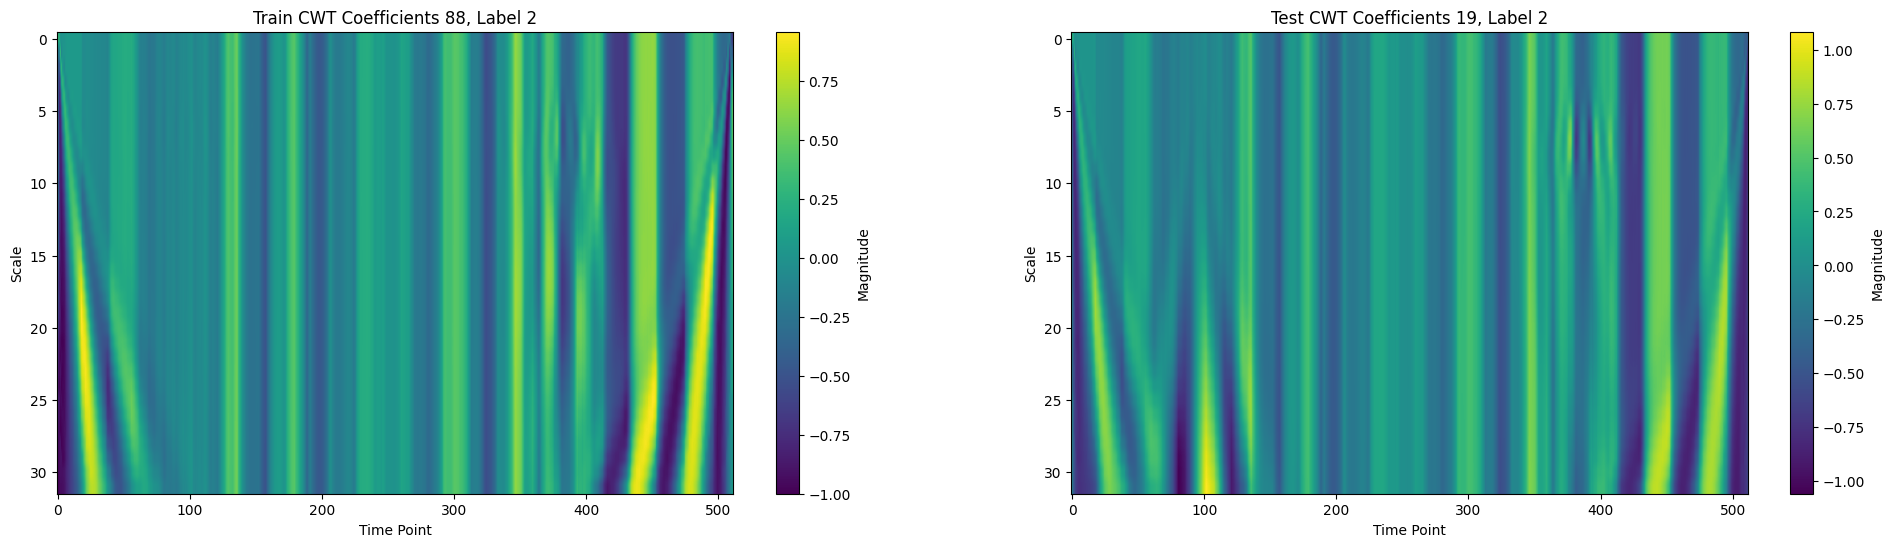

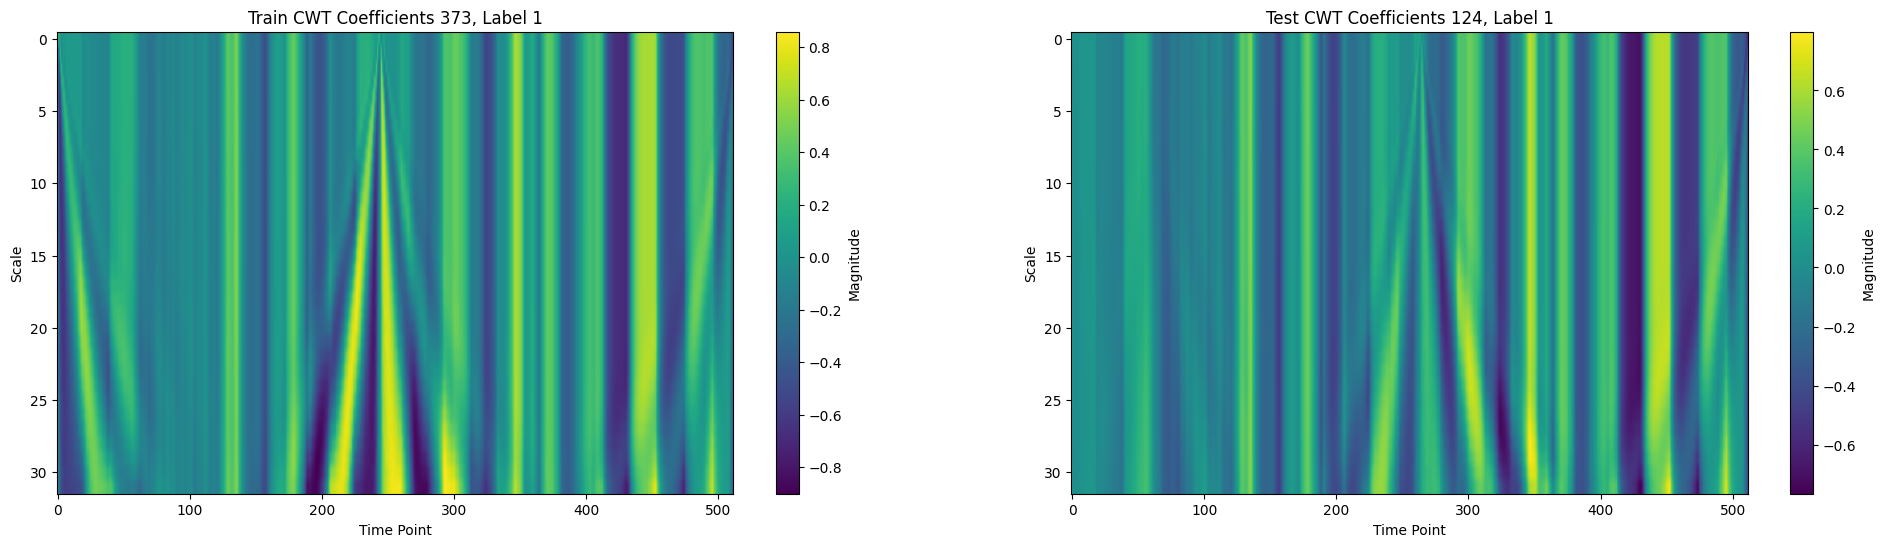

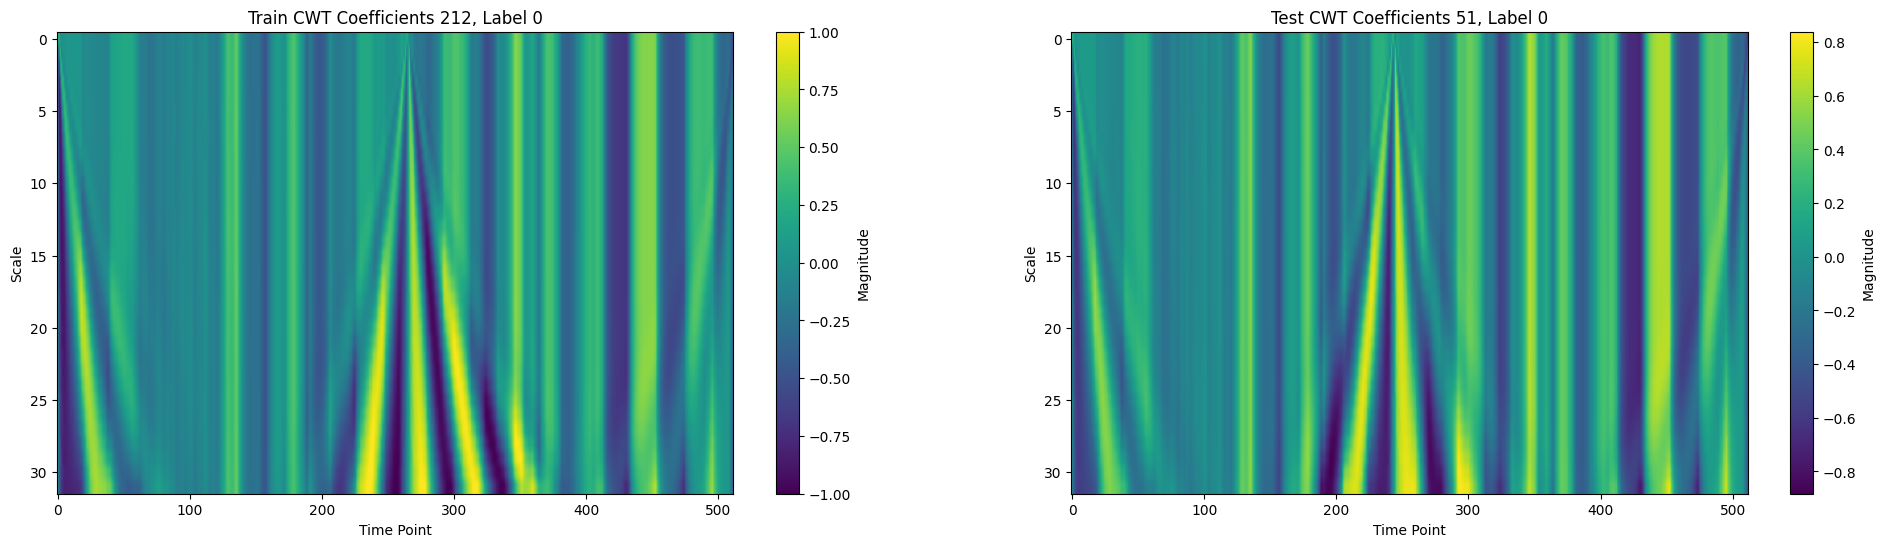

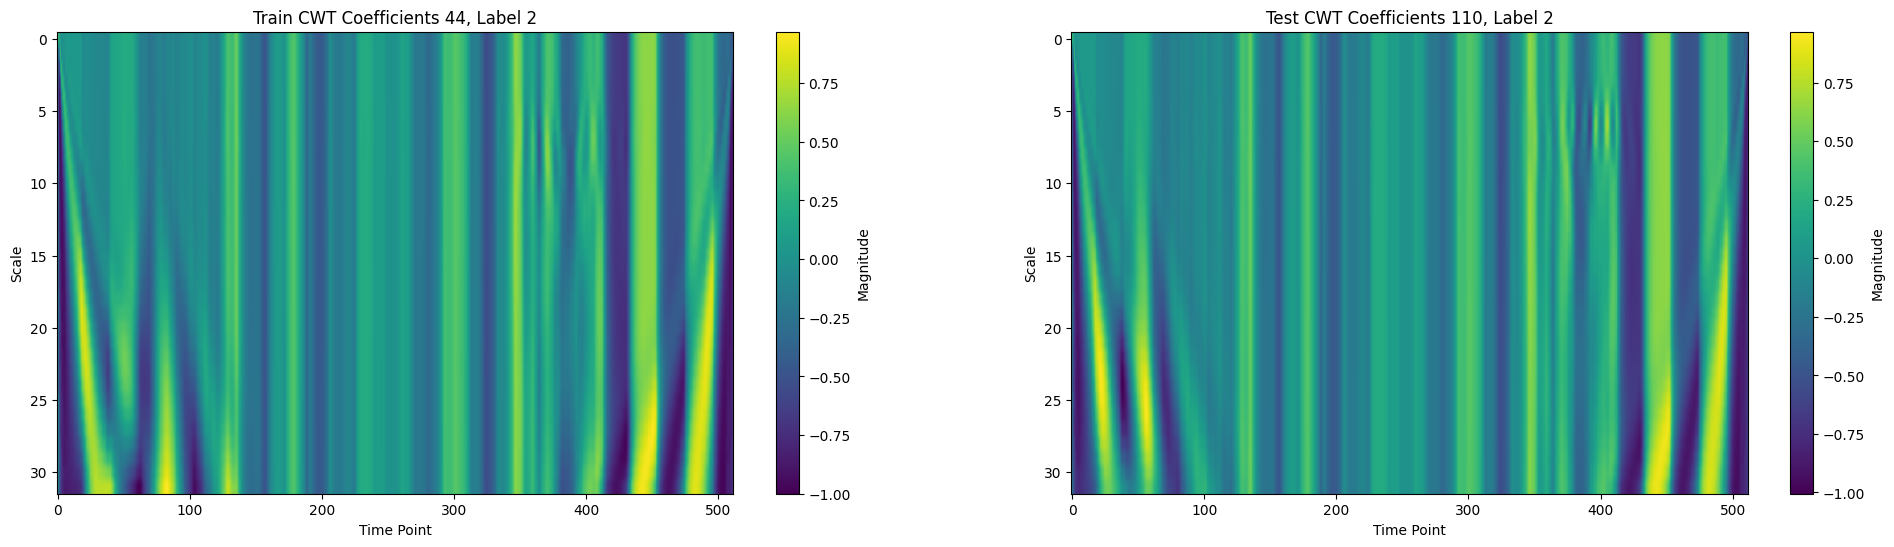

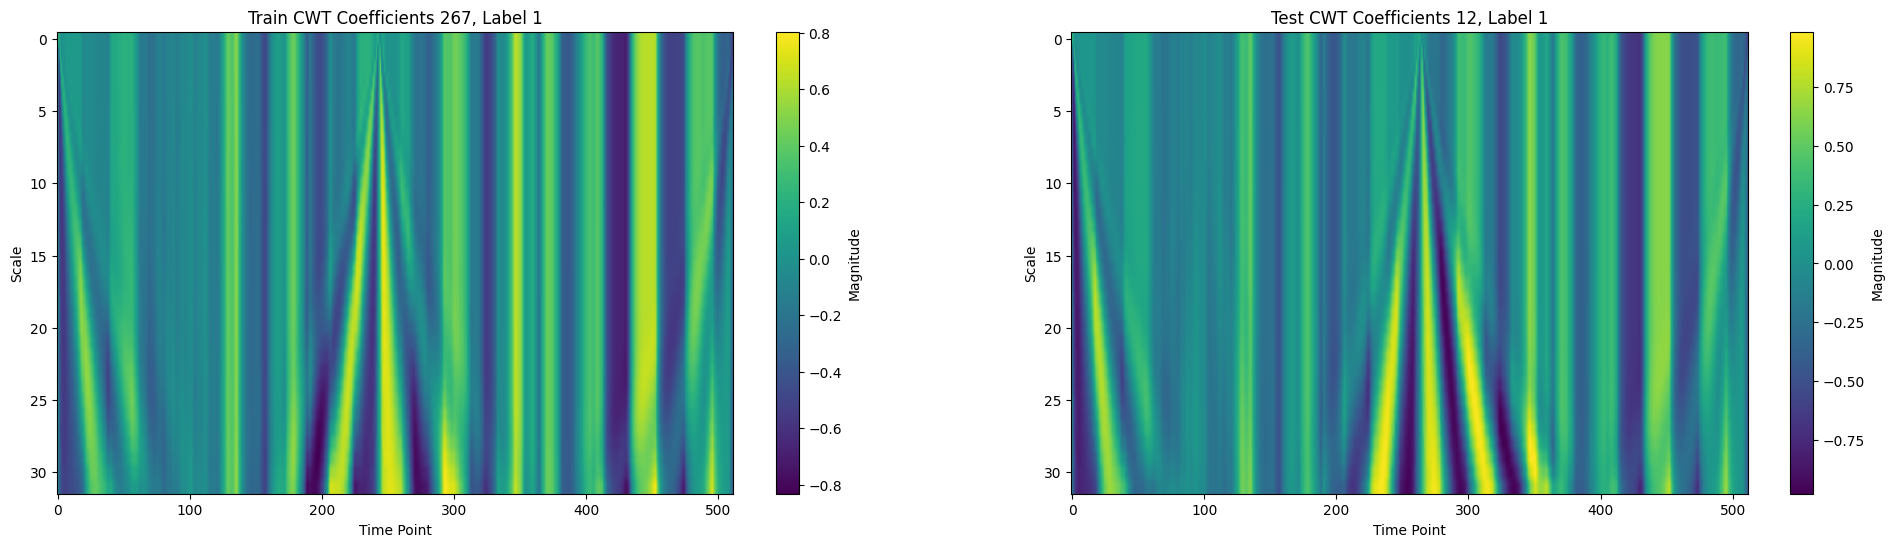

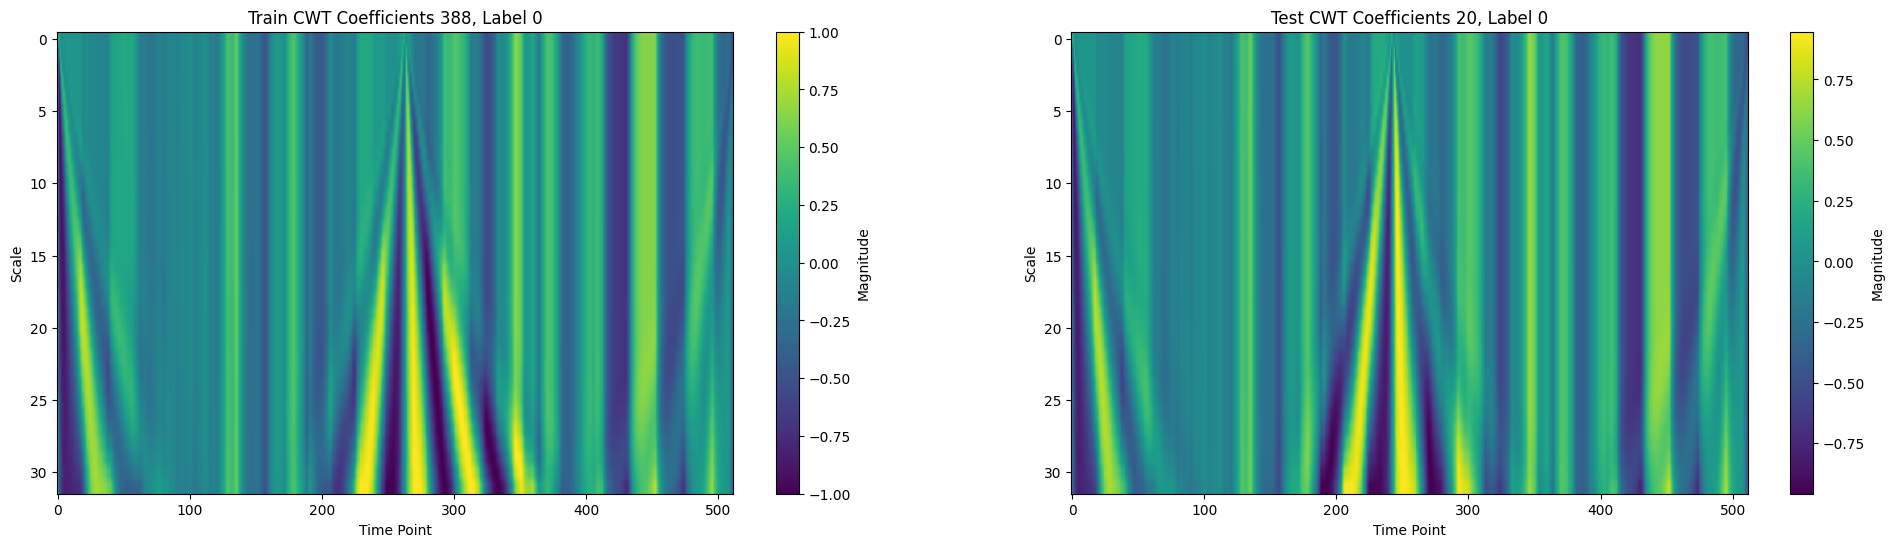

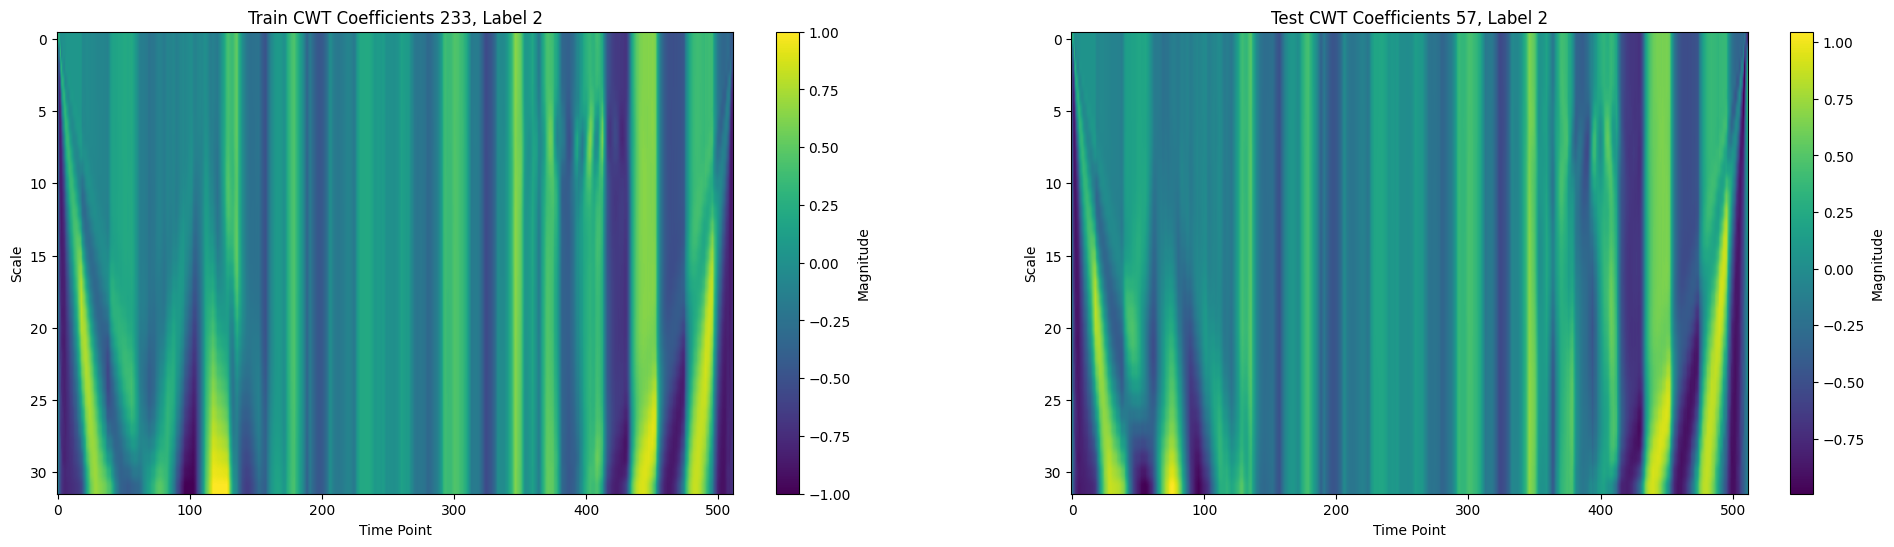

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming cwt_train and cwt_test are your CWT-transformed datasets
for _ in range(25):  # Let's reduce the number for clarity in demonstration
    sample_index_train = random.randint(0, len(X_train) - 1)
    train_sample = X_train[sample_index_train]  # CWT coefficients [channels, scales, time]
    train_label = y_train[sample_index_train]

    match_indices = np.where(y_test == train_label)[0]
    sample_index_test = random.choice(match_indices)
    test_sample = X_test[sample_index_test]  # CWT coefficients [channels, scales, time]

    plt.figure(figsize=(24, 6))

    # Concatenate the channels for train and test samples horizontally
    # concatenated_train = np.hstack(train_sample)
    # concatenated_test = np.hstack(test_sample)

    # Plot train CWT coefficients
    plt.subplot(1, 2, 1)
    plt.imshow(train_sample[1], aspect='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f"Train CWT Coefficients {sample_index_train}, Label {train_label}")
    plt.xlabel("Time Point")
    plt.ylabel("Scale")

    # Plot test CWT coefficients
    plt.subplot(1, 2, 2)
    plt.imshow(test_sample[1], aspect='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f"Test CWT Coefficients {sample_index_test}, Label {y_test[sample_index_test]}")
    plt.xlabel("Time Point")
    plt.ylabel("Scale")

    plt.show()

# import numpy as np
# import matplotlib.pyplot as plt

# for _ in range(25):
#     sample_index_train = random.randint(0, len(X_train) - 1)
#     train_sample = X_train[sample_index_train]
#     train_label = y_train[sample_index_train]

#     match_indices = np.where(y_test == train_label)[0]
#     sample_index_test = random.choice(match_indices)
#     test_sample = X_test[sample_index_test]

#     time_axis = np.arange(train_sample.shape[1])  # Time points on the x-axis

#     plt.figure(figsize=(24, 6))

#     # Plot train sample
#     plt.subplot(1, 2, 1)
#     for channel in range(train_sample.shape[0]):
#         plt.plot(time_axis, train_sample[channel, :], label=f'Channel {channel+1}')
#     plt.title(f"Train Sample {sample_index_train}, Label {train_label}")
#     plt.xlabel("Time Point")
#     plt.ylabel("Signal Amplitude")
#     plt.ylim((-1, 1))
#     plt.legend()
#     plt.grid(True)

#     # Plot test sample
#     plt.subplot(1, 2, 2)
#     for channel in range(test_sample.shape[0]):
#         plt.plot(time_axis, test_sample[channel, :], label=f'Channel {channel+1}')
#     plt.title(f"Test Sample {sample_index_test}, Label {y_test[sample_index_test]}")
#     plt.xlabel("Time Point")
#     plt.ylabel("Signal Amplitude")
#     plt.ylim((-1, 1))
#     plt.legend()
#     plt.grid(True)

#     plt.show()

In [ ]:
features_array2 = features_array.reshape(features_array.shape[0], features_array.shape[3], -1)
X_train2 = X_train.reshape(X_train.shape[0], X_train.shape[3], -1)  # reshaping to (samples, time_points, features)
X_test2 = X_test.reshape(X_test.shape[0], X_test.shape[3], -1)



In [ ]:
features_array = features_array2
X_train = X_train2
X_test = X_test2
print(features_array.shape,X_train.shape,X_test.shape)

(900, 512, 64) (720, 512, 64) (180, 512, 64)


In [ ]:
GLOBAL_SHAPE_LENGTH = features_array.shape[1]
ncomp = features_array.shape[2]

In [ ]:
class Plasticity(gym.Env):
    def __init__(self, images_per_episode=1, dataset=(X_train, y_train), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=-1, high=1,
                                                shape=(GLOBAL_SHAPE_LENGTH,ncomp),
                                                dtype=np.float32)
        self.images_per_episode = images_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):

        done = False
        reward = self.calculate_reward(action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()

        return obs
    
    def calculate_reward(self, action):
      if action == self.expected_action:
          reward = 2
          
      else:
          reward = -2

      return reward
    
    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]


        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            #print(f"Current dataset index: {self.dataset_idx}")
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs

In [ ]:
env = Plasticity()

In [ ]:
env.observation_space.sample()
env.observation_space.sample().shape

(512, 64)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Input
from tensorflow.keras.optimizers import Adam
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n
print(states,actions)

(512, 64) 3


In [ ]:
from keras.layers import PReLU, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, Layer, AveragePooling1D
from keras.regularizers import l1_l2
from tensorflow.keras.utils import register_keras_serializable
import keras.backend as K

    
def build_model(states, actions):
    clear_session()
    model = Sequential([
        Reshape((GLOBAL_SHAPE_LENGTH,ncomp,),input_shape=(1,GLOBAL_SHAPE_LENGTH,ncomp)),
        BatchNormalization(),

        Conv1D(64, kernel_size=7),
        PReLU(),
        BatchNormalization(),

        MaxPooling1D(pool_size=2),
        SpatialDropout1D(0.1),

        Conv1D(128, kernel_size=5),
        BatchNormalization(),
        PReLU(),
        AveragePooling1D(pool_size=2),
        SpatialDropout1D(0.1),

        LSTM(128, activation='tanh', recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),return_sequences=True),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        BatchNormalization(),
        Dense(units=128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(units=64, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(units=actions, activation='linear')
    ])
    return model

In [ ]:
import tensorflow as tf
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from keras import __version__
model = build_model(states, actions)
model.summary()


Instructions for updating:
Colocations handled automatically by placer.


2024-04-21 10:50:41.511292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 10:50:41.525128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 512, 64)           0         
                                                                 
 batch_normalization (Batch  (None, 512, 64)           256       
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 506, 64)           28736     
                                                                 
 p_re_lu (PReLU)             (None, 506, 64)           32384     
                                                                 
 batch_normalization_1 (Bat  (None, 506, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1  (None, 253, 64)           0

In [ ]:
def build_agent(model, actions):
    policy = EpsGreedyQPolicy(eps=0.1)
    memory = SequentialMemory(limit=1000000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-4)
    return dqn, policy

In [ ]:
dqn, policy = build_agent(model, actions)
dqn.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.0055,decay=1e-4), metrics=['mse'])

2024-04-21 10:50:42.361292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-04-21 10:50:42.428794: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_6_1/moving_mean/Assign' id:1649 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_6_1/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_6_1/moving_mean, batch_normalization_6_1/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
from rl.callbacks import Callback

class LossHistory(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][0])

class LossHistory2(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][1])

class RewardHistory(Callback):
    def on_train_begin(self, logs={}):
        self.rewards = []

    def on_episode_end(self, episode, logs={}):
        self.rewards.append(logs['episode_reward'])

class ExponentialDecayEpsilonCallback(Callback):
    def __init__(self, initial_epsilon, min_epsilon, decay_rate, decay_steps):
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.step_count = 0

    def on_step_end(self, step, logs={}):
        self.step_count += 1
        self.epsilon = self.min_epsilon + (self.epsilon - self.min_epsilon) * np.exp(-self.step_count / self.decay_steps)
        self.model.policy.eps = max(self.epsilon, self.min_epsilon)
        #print(f"Step: {self.step_count}, New Epsilon: {self.epsilon}")



initial_epsilon = 1.0  
min_epsilon = 0.0 
decay_rate = 0.0001     
decay_steps = 100000    
epsilon_decay_cb = ExponentialDecayEpsilonCallback(initial_epsilon, min_epsilon, decay_rate, decay_steps)


loss_history = LossHistory()
loss_history2 = LossHistory2()
reward_history = RewardHistory()


dqn.fit(env, nb_steps=6000, callbacks=[loss_history,loss_history2,reward_history,epsilon_decay_cb], verbose=1)
dqn.policy.eps = 0
dqn.fit(env, nb_steps=200, callbacks=[loss_history,loss_history2,reward_history], verbose=1)
dqn.fit(env, nb_steps=200, callbacks=[loss_history,loss_history2,reward_history], verbose=1)

Training for 6000 steps ...
Interval 1 (0 steps performed)


/home/eeshan/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-04-21 10:50:42.879689: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_2/BiasAdd' id:862 op device:{requested: '', assigned: ''} def:{{{node dense_2/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_2/MatMul, dense_2/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-21 10:50:42.952585: W tensorflow/c/c_api.cc:304] Operation '{name:'total/Assign' id:2402 op device:{requested: '', assigned: ''} def:{{{node total/Assign}} = AssignVariableOp[_has_manual_control_depend

  100/10000 [..............................] - ETA: 1:58 - reward: -1.0400

2024-04-21 10:50:44.372679: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_2_1/BiasAdd' id:1721 op device:{requested: '', assigned: ''} def:{{{node dense_2_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_2_1/MatMul, dense_2_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-21 10:50:45.164317: W tensorflow/c/c_api.cc:304] Operation '{name:'batch_normalization_6/cond_3/Identity' id:816 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_6/cond_3/Identity}} = Identity[T=DT_FLOAT, _has_manual_control_dependencies=true](batch_normalization_6/cond_3)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after 

 6000/10000 [=================>............] - ETA: 22:52 - reward: 1.2653done, took 2059.571 seconds
Training for 200 steps ...
Interval 1 (0 steps performed)
  200/10000 [..............................] - ETA: 31:35 - reward: 1.6000done, took 38.677 seconds
Training for 200 steps ...
Interval 1 (0 steps performed)
  200/10000 [..............................] - ETA: 31:10 - reward: 1.7600done, took 38.186 seconds


In [ ]:
class TestPhaseLogger(Callback):
    def __init__(self, env):
        
        self.env = env

    def on_action_end(self, action, logs={}):
       
        if not self.model.training and self.env.calculate_reward(action) > 0:
            print(f"Correct Action: {action}, Reward Gained")
        elif not self.model.training and self.env.calculate_reward(action) < 0:
            print(f"Wrong Action: {action}, Correct Action {self.env.y[self.env.dataset_idx-1]}, Penalty Incurred")
test_logger = TestPhaseLogger(env)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from rl.policy import GreedyQPolicy
dqn.policy = GreedyQPolicy()

def dqn_eval(dqn_agent,d):
    attempts, correct = 0, 0
    labels = d[1]
    eenv = Plasticity(dataset=d, random=False)
    thing = 1
    y_predFull = []
    y_trueest = []
    total_reward = 0
    try:
        while True:
            if thing == 1:
                obs = eenv.reset()
                thing = 0
            done = False
            while not done:

                obs_reshaped = np.reshape(obs, (1,) + obs.shape)

                q_values = dqn_agent.compute_q_values(obs_reshaped)
                #print(q_values)

                action = np.argmax(q_values)
                
                #print('action: ', action, " - ", labels[attempts])
                y_predFull.append(action)
                y_trueest.append(labels[attempts])

                obs, rew, done, _ = eenv.step(action)
                if(rew == 2):
                    print(f"Correct Action: {action}, Reward Gained: {rew}")
                else:
                    print(f"Wrong Action: {action}, Correct Action {labels[attempts]}, Reward Gained: {rew}")
                total_reward += rew
                if done:
                    attempts += 1
    except StopIteration:
        print()
        print('Validation done...','total reward=',total_reward+1)

        y_predFull = np.array(y_predFull)
        y_trueest = np.array(y_trueest)

        cm = confusion_matrix(y_trueest, y_predFull)
        print(y_predFull)
        print(y_trueest)

        print("Confusion Matrix:\n", cm)

        report = classification_report(y_trueest, y_predFull,digits=4)
        print("Classification Report:\n", report)

        report = classification_report(y_trueest, y_predFull,output_dict=True)

        correct = sum(y_predFull == y_trueest)
        attempts = len(y_trueest)
        accuracy = (float(correct) / attempts)
        print('Validation done...')
        print('Accuracy: {:.2f}%'.format(accuracy*100))

        F1 = report['macro avg']['f1-score']
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']

        print("F1 Score: {:.2f}%".format(F1*100))
        print("Precision: {:.2f}%".format(precision*100))
        print("Recall: {:.2f}%".format(recall*100))

    y_predFull = []
    y_trueest = []
    return accuracy, F1, precision, recall

dqn_eval(dqn,d=(X_train,y_train))
print('***************************************************************************************')
dqn_eval(dqn,d=(X_test,y_test))
print('***************************************************************************************')

def dqn_eval2(d,split=10):
     
    n_splits = split
    mean_rewards_per_fold = []
    acc_per_fold = []
    f1_mean, p_mean, r_mean = [], [], []
    # Loop over each fold
    
    skf = StratifiedKFold(n_splits=n_splits)
    train, test = d
    for train_index, test_index in skf.split(train,test):
        xtr, xte = train[train_index],train[test_index]
        ytr, yte = test[train_index], test[test_index]

        test_env = Plasticity(dataset = (xte, yte),random=True)
        
        scores = dqn.test(test_env, nb_episodes=10, visualize=False, verbose=0)
        acc, f1, p, r = dqn_eval(dqn,d=(xte, yte))
        
        mean_reward = np.mean(scores.history['episode_reward'])
        mean_rewards_per_fold.append(mean_reward)
        acc_per_fold.append(acc)
        f1_mean.append(f1)
        r_mean.append(r)
        p_mean.append(p)
   
    overall_mean_reward = np.mean(mean_rewards_per_fold)

    #print(acc_per_fold)
    
    f1_avg, p_avg, r_avg = np.mean(f1_mean), np.mean(p_mean), np.mean(r_mean)
    #print(mean_rewards_per_fold)
    print(f"Overall Mean Reward across all folds: {overall_mean_reward * 100} %")
    acc_avg = np.mean(acc_per_fold)
    print(f"Overall Mean Accuracy across all folds: {acc_avg * 100} %")
    #print(f1_mean)
    print(f"Overall Mean F1 across all folds: {f1_avg * 100} %")
    #print(p_mean)
    print(f"Overall Mean Precision across all folds: {p_avg * 100} %")
    #print(r_mean)
    print(f"Overall Mean Recall across all folds: {r_avg * 100} %")
#dqn_eval2(d=(X_train,y_train))

dqn_eval2(d=(features_array,label_array))
#dqn_eval(dqn,d=(features_array,label_array))

Correct Action: 2, Reward Gained: 2
Wrong Action: 0, Correct Action 1, Reward Gained: -2
Correct Action: 2, Reward Gained: 2
Wrong Action: 0, Correct Action 1, Reward Gained: -2
Correct Action: 1, Reward Gained: 2
Wrong Action: 0, Correct Action 1, Reward Gained: -2
Correct Action: 0, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Wrong Action: 0, Correct Action 1, Reward Gained: -2
Correct Action: 0, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Wrong Action: 0, Correct Action 1, Reward Gained: -2
Correct Action: 1, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Correct Action:

In [ ]:

dqn_eval(dqn,d=(X_test,y_test))

Correct Action: 0, Reward Gained: 2
Wrong Action: 0, Correct Action 1, Reward Gained: -2
Correct Action: 1, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Wrong Action: 1, Correct Action 0, Reward Gained: -2
Correct Action: 2, Reward Gained: 2
Correct Action: 1, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Correct Action: 0, Reward Gained: 2
Correct Action: 2, Reward Gained: 2
Wrong Action: 0, Correct Action 1, Reward Gained: -2
Wrong Action: 0, Correct Action 1, Reward Gained: -2
Correct Action: 1, Reward Gained: 2
Correct Action: 2, Reward Gained

(0.8491620111731844,
 0.8494032494032494,
 0.8554621848739495,
 0.8499058380414312)

Testing for 10 episodes ...
Correct Action: 0, Reward Gained
Episode 1: reward: 2.000, steps: 1
Correct Action: 1, Reward Gained
Episode 2: reward: 2.000, steps: 1
Wrong Action: 0, Correct Action 2, Penalty Incurred
Episode 3: reward: -2.000, steps: 1
Correct Action: 2, Reward Gained
Episode 4: reward: 2.000, steps: 1
Wrong Action: 0, Correct Action 2, Penalty Incurred
Episode 5: reward: 2.000, steps: 1
Wrong Action: 1, Correct Action 2, Penalty Incurred
Episode 6: reward: 2.000, steps: 1
Wrong Action: 1, Correct Action 2, Penalty Incurred
Episode 7: reward: 2.000, steps: 1
Correct Action: 1, Reward Gained
Episode 8: reward: -2.000, steps: 1
Wrong Action: 1, Correct Action 2, Penalty Incurred
Episode 9: reward: 2.000, steps: 1
Correct Action: 2, Reward Gained
Episode 10: reward: 2.000, steps: 1
120.0 %


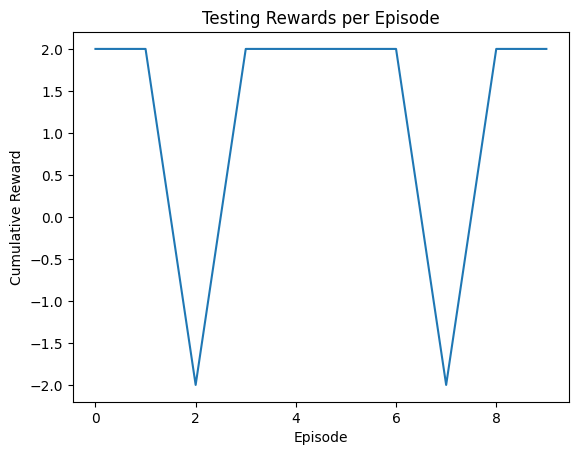

120.0 %
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 

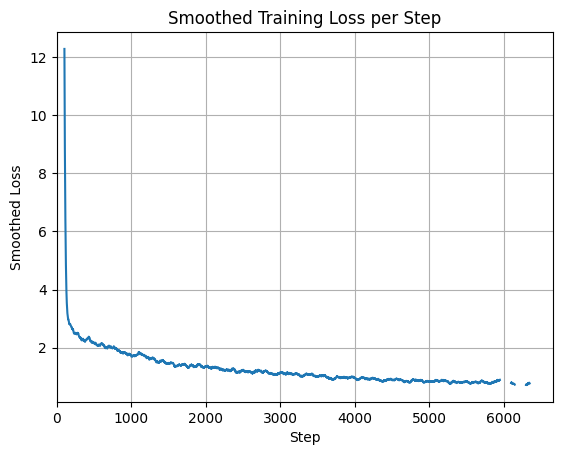

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 2.418148, 2.3930833, 2.379152, 2.3594947, 2.3410408, 2.3239083, 2.3039632, 2.2873564, 2.2786021, 2.261444, 2.241444, 2.2338772, 2.2147372, 2.2073524, 2.1977139, 2.1948671, 2.1944506, 2.1985626, 2.2008681, 2.1959777, 2.203966, 2.1981003, 2.19105, 2.1849566, 2.1884887, 2.1775799, 2.1713262, 2.1597865, 2.1440952, 2.1487365, 2.1486447, 2.1573014, 2.1578455, 2.1557958, 2.1384206, 2.1347797, 2.123245, 2.1121967, 2.1124263, 2.1100435, 2.103072, 2.1043303, 2.1045685, 2.0997427, 2.1055899, 2.101906

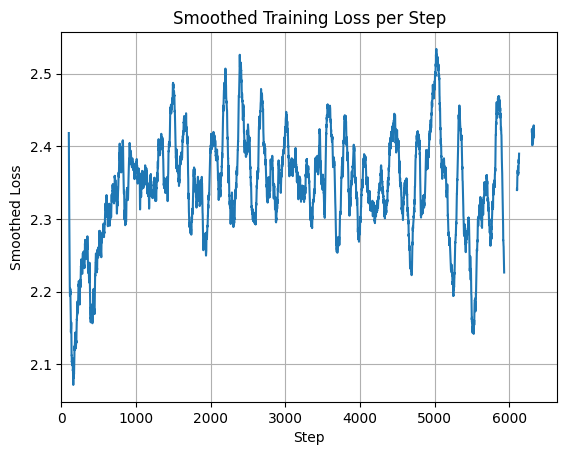

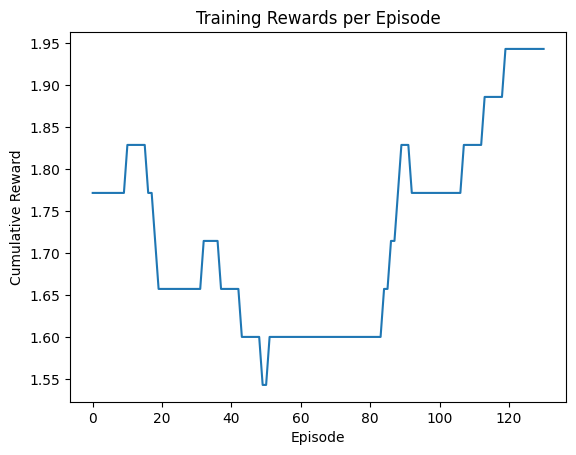

___________________________________________________________________________________________________________________________


In [ ]:
scores = dqn.test(Plasticity(images_per_episode=1,random=True,dataset=(X_test,y_test)), callbacks=[test_logger],nb_episodes=10, visualize=False, action_repetition=1, verbose=1)
print(np.mean(scores.history['episode_reward'])*100,'%')
plt.plot(scores.history['episode_reward'])
plt.title('Testing Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()
print(np.mean(scores.history['episode_reward'])*100,'%')
print(label_array,label_array.shape)

dqn_eval(dqn,d=(features_array,label_array))
def moving_average(data, window_size):
    return [np.mean(data[i:i+window_size]) for i in range(len(data) - window_size + 1)]
losses = loss_history.losses
losses2 = loss_history2.losses
smoothed_losses = moving_average(losses, window_size=50)
print(smoothed_losses)
plt.plot(smoothed_losses)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

smoothed_losses2 = moving_average(losses2, window_size=70)
print(smoothed_losses2)
plt.plot(smoothed_losses2)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

plt.plot(moving_average(reward_history.rewards, window_size=70))
plt.title('Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()

print("___________________________________________________________________________________________________________________________")




